In [1]:
import argparse
from itertools import product as iterprod
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from argparse import ArgumentParser
import time
from datetime import datetime
from tqdm.autonotebook import tqdm
import pandas as pd

import matplotlib.pyplot as plt



/tmp/ipykernel_509345/3724148964.py:12: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
import utils.data67_processing as dp


from utils.UNeXt import UNet
from utils.loss_inference import loss_function_dict

import utils.nb_utils as nb_utils

import pprint

np.random.seed(11) # for reproducibility
torch.manual_seed(11)


%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
batch_size = 4
num_workers = 2

# Device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
pin_memory = True if torch.cuda.is_available() else False

In [4]:
device


device(type='cuda', index=0)

# Build dataset

In [5]:
# Dataset
directory  = '/mnt/d/lding/FA/analysis_results/pFAK_zyxin_20230423/combined_npy_grouped_normalized/'

test_cells = 'cell_3'


in_channels  = [7] # Example: [[4], [4,6], [4,6,7]]. Channel 4 is mask, 6 is zyxin, 7 is other protein (here actin)
out_channels = (6)
transform_kwargs = {'crop_size': 512,
                    'output_channels': out_channels,
                    'norm_output': {'rescale': 1, 'threshold': 0.0004}
                    }

dataset_kwargs = { 
                    'root': directory,
                    'force_load': False,
                    'test_split': 'bycell',
                    'test_cells': test_cells,
                    'in_channels': in_channels, 
                    'out_channels': out_channels, 
                    'transform_kwargs': transform_kwargs,
                    'frames_to_keep': 256,
                    'input_baseline_normalization': 'none', # Comment on what these do
                    'output_baseline_normalization': 'none',
                    'remake_dataset_csv': True
                     }


dataset = dp.CellDataset( **dataset_kwargs )

train_loader = dataset.get_loader(dataset.train_indices, batch_size, num_workers, pin_memory)
validation_loader = dataset.get_loader(dataset.test_indices, batch_size, num_workers, pin_memory)

{'crop_size': 512, 'output_channels': 6, 'norm_output': {'rescale': 1, 'threshold': 0.0004}}


In [6]:
dataset_kwargs['in_channels'][0]

7

# Some visualizations of the training data

The dataset class gets items by looking into a dataframe (`dataset.info`) where the folders and filenames are stored. Folders correspond to single cells, and each file is a frame of the time series. 

`dataset.info` contains the normalization values which the data is normalized by before it is passed to the NN. Forces are normalized by `dataset.info.F_mean` and the zyxin signal is normalized by `dataset.info.zyxin_baseline_out` and `dataset.info.zyxin_baseline_in`. Details about how these are generated can be found in the DataProcessing notebook.
    


In [7]:
df = dataset.info.copy()

# df.head(10)

In [8]:
# Print test cells: 
print(dataset.test_cells)
print(dataset.test_indices)

{'test_cells': ['cell_3']}
[48 18 89 93 22 44 45  6 24 75 67 69 26  0  1 68 51 20 38 41 60 62 21  5
 33 59 50 28 35 25 82  9 39 88 46 90 85 16  3 12 63 15 40 14 61 17  4 49
 86 80 98]


In [9]:
# dataset.info

In [10]:
cell = 'cell_1'
frame = 10

idx = dataset.info.index[(dataset.info.folder==cell)&(dataset.info.frame==frame)].tolist()[0] # Get index in dataframe that contains the right cell and frame.
print(idx)

dataset.out_channels

sample = dataset[idx]

210


{'mask': torch.Size([1, 512, 512]), 'weight': torch.Size([1, 512, 512]), 'input_seg': torch.Size([1, 512, 512]), 'output_seg': torch.Size([1, 512, 512]), 'input': torch.Size([1, 1, 512, 512]), 'output': torch.Size([1, 512, 512]), 'zyxin': torch.Size([1, 512, 512]), 'actin': torch.Size([1, 512, 512])}


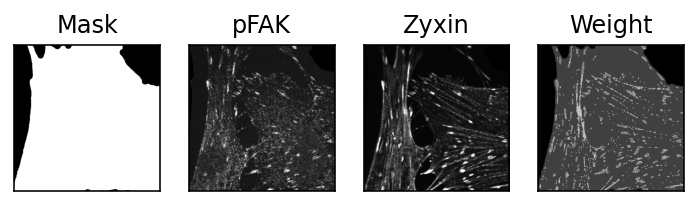

In [11]:
fig,ax=plt.subplots(1,4,figsize=(2*3, 4*2), dpi=144)

print({key: sample[key].shape for key in sample.keys()})

ax[0].set_title('Mask')
ax[0].imshow(sample['mask'].squeeze(), origin='lower', cmap='gray', vmax=1, vmin=0)
ax[1].set_title('pFAK')
ax[1].imshow(sample['input'].squeeze(), origin='lower', cmap='gray', vmax=1, vmin=0)
ax[2].set_title('Zyxin')
ax[2].imshow(sample['output'].squeeze(), origin='lower', cmap='gray', vmax=1, vmin=0)
ax[3].set_title('Weight')
ax[3].imshow(sample['weight'][0,:,:].squeeze(), origin='lower', cmap='gray', vmax=4, vmin=0)


for a in ax.flat:
    a.set_xticks([])
    a.set_yticks([])

### Build U-Net model with ConvNext blocks

In [ ]:
n_lyr  = 3 # number of downsampling layers
ds_krnl= 4 # downsample kernel
n_ch   = 4 # number of channels in the beginning of the network
n_blocks = 4 # number of ConvNext blocks, wherever ConvNext blocks are used

prepend_hparams = {'start_channel': 1, 'resnet_channel': n_ch, 'end_channel': n_ch, 'N_blocks': n_blocks,                                         # Args for architecture
                    'kernel': 7,'stride': 1, 'inv_bottleneck_factor': 4, 'dilation': 1,'dropout_rate': 0.1, 'activation': 'gelu', 'batchnorm': 1} # Args for ConvNext blocks
encoder_hparams = {'n_ch': n_ch, 'n_layers': n_lyr, 'N_node_blocks': n_blocks, 'N_skip_blocks': n_blocks,
                    'downsample_kwargs': {'kernel': ds_krnl, 'activation': 'gelu', 'batchnorm': 1},
                    'interlayer_kwargs': {'kernel': 7,'stride': 1, 'inv_bottleneck_factor': 4, 'dilation': 1,'dropout_rate': 0.1, 'activation': 'gelu', 'batchnorm': 1}
                    }
decoder_hparams = {'n_layers': n_lyr, 'N_node_blocks': n_blocks, 'upsample_kernel': ds_krnl,
                    'kernel': 7,'stride': 1, 'inv_bottleneck_factor': 4, 'dilation': 1,'dropout_rate': 0.1, 'activation': 'gelu', 'batchnorm': 1}
append_hparams = {'start_channel': n_ch, 'resnet_channel': n_ch, 'end_channel': 1, 'N_blocks': n_blocks,
                    'kernel': 7,'stride': 1, 'inv_bottleneck_factor': 8, 'dilation': 1,'dropout_rate': 0.1, 'activation': 'gelu', 'batchnorm': 1} 
optimizer_hparams = {'LR': 0.001, 'schedule_rate': 0.99}
loss_hparams = {'loss_type': 'aw_mse_corr',
                'exp_weight': 0.0,
                'strainenergy_regularization': 0.0,
                'exp_schedule': {'type': 'linear', 'width': 310, 'e_crit': 30},
                'reg_schedule': {'type': 'linear', 'width': 310, 'e_crit': 30},
                'loss_kwargs': {'max_force': 8.}
               }

n_epochs = 500

modelname = 'rerun20251212_protein1_datanormed_model_pfak2zyxin_aw_mse_corr_'+str(n_epochs)+'ep'

logger_params = {'log_dir': f'./tensorboard_logs/{modelname}', 
                    'image_epoch_freq': 10,
                    'image_callbacks': 'vectorfield,hists',
                    'save_model_freq': 4}

# Actually build model:
model_kwargs={
                'input_type':  'actin', 
                'prepend_hparams': prepend_hparams, 
                'encoder_hparams': encoder_hparams, 
                'decoder_hparams': decoder_hparams, 
                'append_hparams': append_hparams, 
                'optimizer_hparams': optimizer_hparams,
                'loss_hparams': loss_hparams,
                'logger_params': logger_params,
                'name': modelname}


model = UNet( **model_kwargs, model_idx=0)
model.to(device)


UNet(
  (layers_encode): ModuleList(
    (0): ModuleList(
      (0-3): 4 x ConvNextCell(
        (conv0): Conv2d(4, 4, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=4)
        (conv1): Conv2d(4, 16, kernel_size=(1, 1), stride=(1, 1))
        (conv2): Conv2d(16, 4, kernel_size=(1, 1), stride=(1, 1))
        (bn): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): GELU(approximate='none')
      )
      (4): DownsampleLayer(
        (conv): Conv2d(4, 8, kernel_size=(4, 4), stride=(4, 4))
        (bn): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): GELU(approximate='none')
      )
    )
    (1): ModuleList(
      (0-3): 4 x ConvNextCell(
        (conv0): Conv2d(8, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=8)
        (conv1): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        (conv2): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
        (bn): BatchNorm2d(8, eps=

# Perform training

In [13]:
save_models = True

pbar = tqdm(total=n_epochs*(np.minimum(dataset.frames_to_keep, len(dataset.train_indices))/batch_size))

t0 = time.time()
for e in range(n_epochs):
    pbar.set_description(f'Epoch {e}')
    loss_values_train = {}
    loss_values_val = {}

    model.reset_running_train_loss()
    model.reset_running_val_loss()

    for sample in train_loader: 
        for key in sample:
            sample[key] = sample[key].to(device)
        
        model.training_step(sample, epoch=e) # loss.backward() and optimizer step occur in here
        
        pbar.update(1)

    for sample in validation_loader:
        for key in sample:
            sample[key] = sample[key].to(device)     
    
        model.validation_step(sample, epoch=e)

    model.scheduler.step()    
    print("Epoch %u:\t Time: %0.2f \t(per epoch: %0.2f), loss=%0.3f"%(e, time.time()-t0, (time.time()-t0)/(e+1),model.get_running_val_loss()['aw_mse_corr_loss']))
    
    # SAVE
    if save_models:
        # Log in tensorboard
        model.log_scalars(epoch=e) 
            
        # Save models
        if e%(logger_params['save_model_freq'])==0 or e==n_epochs-1: 
            torch.save({'model': model.state_dict(),
                        'model_kwargs': model_kwargs,
                        'model_name': model.name,
                        'model_idx': model.index,
                        'dataset_kwargs': dataset_kwargs,
                        'test_cells': dataset.test_cells,
                        }, 
                       os.path.join( model.logdir, 'model.pt') )


Epoch 1:   0%|          | 64/32000.0 [00:37<3:35:44,  2.47it/s]

Epoch 0:	 Time: 37.58 	(per epoch: 37.58), loss=7.141


Epoch 2:   0%|          | 128/32000.0 [01:14<3:38:13,  2.43it/s]

Epoch 1:	 Time: 74.68 	(per epoch: 37.34), loss=6.465


Epoch 3:   1%|          | 192/32000.0 [01:51<3:41:47,  2.39it/s] 

Epoch 2:	 Time: 111.94 	(per epoch: 37.31), loss=5.294


Epoch 4:   1%|          | 256/32000.0 [02:29<3:36:11,  2.45it/s] 

Epoch 3:	 Time: 149.11 	(per epoch: 37.28), loss=12.630


Epoch 5:   1%|          | 320/32000.0 [03:06<3:41:17,  2.39it/s] 

Epoch 4:	 Time: 186.49 	(per epoch: 37.30), loss=4.863


Epoch 6:   1%|          | 384/32000.0 [03:44<3:29:29,  2.52it/s] 

Epoch 5:	 Time: 224.16 	(per epoch: 37.36), loss=6.641


Epoch 7:   1%|▏         | 448/32000.0 [04:21<3:41:50,  2.37it/s] 

Epoch 6:	 Time: 261.24 	(per epoch: 37.32), loss=5.761


Epoch 8:   2%|▏         | 512/32000.0 [04:57<3:34:13,  2.45it/s] 

Epoch 7:	 Time: 297.98 	(per epoch: 37.25), loss=7.564


Epoch 9:   2%|▏         | 576/32000.0 [05:34<3:37:30,  2.41it/s] 

Epoch 8:	 Time: 334.41 	(per epoch: 37.16), loss=5.925


Epoch 10:   2%|▏         | 640/32000.0 [06:11<3:38:52,  2.39it/s]

Epoch 9:	 Time: 370.99 	(per epoch: 37.10), loss=5.071


Epoch 11:   2%|▏         | 704/32000.0 [06:47<3:29:06,  2.49it/s] 

Epoch 10:	 Time: 407.34 	(per epoch: 37.03), loss=4.804


Epoch 12:   2%|▏         | 768/32000.0 [07:23<3:34:51,  2.42it/s] 

Epoch 11:	 Time: 443.32 	(per epoch: 36.94), loss=3.900


Epoch 13:   3%|▎         | 832/32000.0 [08:00<3:28:15,  2.49it/s] 

Epoch 12:	 Time: 480.43 	(per epoch: 36.96), loss=4.186


Epoch 14:   3%|▎         | 896/32000.0 [08:37<3:33:19,  2.43it/s] 

Epoch 13:	 Time: 517.42 	(per epoch: 36.96), loss=5.488


Epoch 15:   3%|▎         | 960/32000.0 [09:14<3:29:14,  2.47it/s] 

Epoch 14:	 Time: 554.33 	(per epoch: 36.96), loss=5.722


Epoch 16:   3%|▎         | 1024/32000.0 [09:51<3:41:11,  2.33it/s]

Epoch 15:	 Time: 591.63 	(per epoch: 36.98), loss=9.299


Epoch 17:   3%|▎         | 1088/32000.0 [10:28<3:52:09,  2.22it/s] 

Epoch 16:	 Time: 628.32 	(per epoch: 36.96), loss=5.094


Epoch 18:   4%|▎         | 1152/32000.0 [11:05<3:41:16,  2.32it/s] 

Epoch 17:	 Time: 665.93 	(per epoch: 37.00), loss=4.664


Epoch 19:   4%|▍         | 1216/32000.0 [11:45<3:48:15,  2.25it/s] 

Epoch 18:	 Time: 704.98 	(per epoch: 37.10), loss=4.406


Epoch 20:   4%|▍         | 1280/32000.0 [12:23<3:55:20,  2.18it/s] 

Epoch 19:	 Time: 743.13 	(per epoch: 37.16), loss=4.311


Epoch 21:   4%|▍         | 1344/32000.0 [13:01<3:40:21,  2.32it/s] 

Epoch 20:	 Time: 781.47 	(per epoch: 37.21), loss=3.937


Epoch 22:   4%|▍         | 1408/32000.0 [13:42<3:39:19,  2.32it/s] 

Epoch 21:	 Time: 822.54 	(per epoch: 37.39), loss=3.869


Epoch 23:   5%|▍         | 1472/32000.0 [14:22<3:47:57,  2.23it/s] 

Epoch 22:	 Time: 862.02 	(per epoch: 37.48), loss=4.184


Epoch 24:   5%|▍         | 1536/32000.0 [15:00<3:31:55,  2.40it/s] 

Epoch 23:	 Time: 900.29 	(per epoch: 37.51), loss=6.909


Epoch 25:   5%|▌         | 1600/32000.0 [15:39<3:32:38,  2.38it/s] 

Epoch 24:	 Time: 939.14 	(per epoch: 37.57), loss=3.910


Epoch 26:   5%|▌         | 1664/32000.0 [16:17<3:23:27,  2.49it/s] 

Epoch 25:	 Time: 977.32 	(per epoch: 37.59), loss=4.950


Epoch 27:   5%|▌         | 1728/32000.0 [16:54<3:26:59,  2.44it/s] 

Epoch 26:	 Time: 1014.97 	(per epoch: 37.59), loss=3.738


Epoch 28:   6%|▌         | 1792/32000.0 [17:33<3:35:40,  2.33it/s] 

Epoch 27:	 Time: 1053.67 	(per epoch: 37.63), loss=3.976


Epoch 29:   6%|▌         | 1856/32000.0 [18:11<3:33:02,  2.36it/s] 

Epoch 28:	 Time: 1091.56 	(per epoch: 37.64), loss=4.682


Epoch 30:   6%|▌         | 1920/32000.0 [18:49<3:40:54,  2.27it/s] 

Epoch 29:	 Time: 1129.29 	(per epoch: 37.64), loss=4.213


Epoch 31:   6%|▌         | 1984/32000.0 [19:30<3:43:19,  2.24it/s] 

Epoch 30:	 Time: 1170.54 	(per epoch: 37.76), loss=5.073


Epoch 32:   6%|▋         | 2048/32000.0 [20:11<3:38:49,  2.28it/s] 

Epoch 31:	 Time: 1211.92 	(per epoch: 37.87), loss=4.392


Epoch 33:   7%|▋         | 2112/32000.0 [20:52<3:41:20,  2.25it/s] 

Epoch 32:	 Time: 1252.52 	(per epoch: 37.96), loss=5.109


Epoch 34:   7%|▋         | 2176/32000.0 [21:33<3:50:22,  2.16it/s] 

Epoch 33:	 Time: 1293.24 	(per epoch: 38.04), loss=4.905


Epoch 35:   7%|▋         | 2240/32000.0 [22:13<3:55:04,  2.11it/s] 

Epoch 34:	 Time: 1333.56 	(per epoch: 38.10), loss=4.810


Epoch 36:   7%|▋         | 2304/32000.0 [22:54<3:57:39,  2.08it/s] 

Epoch 35:	 Time: 1374.08 	(per epoch: 38.17), loss=4.075


Epoch 37:   7%|▋         | 2368/32000.0 [23:34<3:38:23,  2.26it/s] 

Epoch 36:	 Time: 1414.24 	(per epoch: 38.22), loss=4.152


Epoch 38:   8%|▊         | 2432/32000.0 [24:13<3:43:20,  2.21it/s] 

Epoch 37:	 Time: 1453.90 	(per epoch: 38.26), loss=3.887


Epoch 39:   8%|▊         | 2496/32000.0 [24:53<3:31:54,  2.32it/s] 

Epoch 38:	 Time: 1493.25 	(per epoch: 38.29), loss=3.473


Epoch 40:   8%|▊         | 2560/32000.0 [25:30<3:37:21,  2.26it/s] 

Epoch 39:	 Time: 1530.70 	(per epoch: 38.27), loss=5.056


Epoch 41:   8%|▊         | 2624/32000.0 [26:09<3:30:54,  2.32it/s] 

Epoch 40:	 Time: 1569.09 	(per epoch: 38.27), loss=4.904


Epoch 42:   8%|▊         | 2688/32000.0 [26:48<3:28:31,  2.34it/s] 

Epoch 41:	 Time: 1608.21 	(per epoch: 38.29), loss=4.102


Epoch 43:   9%|▊         | 2752/32000.0 [27:25<3:29:10,  2.33it/s] 

Epoch 42:	 Time: 1645.61 	(per epoch: 38.27), loss=6.449


Epoch 44:   9%|▉         | 2816/32000.0 [28:06<3:47:04,  2.14it/s] 

Epoch 43:	 Time: 1686.31 	(per epoch: 38.33), loss=4.054


Epoch 45:   9%|▉         | 2880/32000.0 [28:47<3:36:06,  2.25it/s] 

Epoch 44:	 Time: 1727.16 	(per epoch: 38.38), loss=5.251


Epoch 46:   9%|▉         | 2944/32000.0 [29:28<3:27:48,  2.33it/s] 

Epoch 45:	 Time: 1768.28 	(per epoch: 38.44), loss=3.966


Epoch 47:   9%|▉         | 3008/32000.0 [30:07<3:24:31,  2.36it/s] 

Epoch 46:	 Time: 1807.48 	(per epoch: 38.46), loss=4.219


Epoch 48:  10%|▉         | 3072/32000.0 [30:45<3:29:50,  2.30it/s] 

Epoch 47:	 Time: 1845.33 	(per epoch: 38.44), loss=4.899


Epoch 49:  10%|▉         | 3136/32000.0 [31:23<3:34:19,  2.24it/s] 

Epoch 48:	 Time: 1883.88 	(per epoch: 38.45), loss=4.118


Epoch 50:  10%|█         | 3200/32000.0 [32:02<3:23:36,  2.36it/s] 

Epoch 49:	 Time: 1922.61 	(per epoch: 38.45), loss=4.513


Epoch 51:  10%|█         | 3264/32000.0 [32:41<3:29:23,  2.29it/s] 

Epoch 50:	 Time: 1961.55 	(per epoch: 38.46), loss=3.412


Epoch 52:  10%|█         | 3328/32000.0 [33:20<3:31:32,  2.26it/s] 

Epoch 51:	 Time: 2000.39 	(per epoch: 38.47), loss=4.692


Epoch 53:  11%|█         | 3392/32000.0 [33:58<3:29:22,  2.28it/s] 

Epoch 52:	 Time: 2038.76 	(per epoch: 38.47), loss=4.354


Epoch 54:  11%|█         | 3456/32000.0 [34:37<3:26:32,  2.30it/s] 

Epoch 53:	 Time: 2077.30 	(per epoch: 38.47), loss=3.877


Epoch 55:  11%|█         | 3520/32000.0 [35:15<3:13:01,  2.46it/s] 

Epoch 54:	 Time: 2115.71 	(per epoch: 38.47), loss=5.274


Epoch 56:  11%|█         | 3584/32000.0 [35:54<3:19:29,  2.37it/s] 

Epoch 55:	 Time: 2154.06 	(per epoch: 38.47), loss=3.520


Epoch 57:  11%|█▏        | 3648/32000.0 [36:32<3:22:58,  2.33it/s] 

Epoch 56:	 Time: 2192.35 	(per epoch: 38.46), loss=4.639


Epoch 58:  12%|█▏        | 3712/32000.0 [37:10<3:22:46,  2.33it/s] 

Epoch 57:	 Time: 2230.51 	(per epoch: 38.46), loss=4.013


Epoch 59:  12%|█▏        | 3776/32000.0 [37:48<3:19:36,  2.36it/s] 

Epoch 58:	 Time: 2268.63 	(per epoch: 38.45), loss=4.229


Epoch 60:  12%|█▏        | 3840/32000.0 [38:27<3:26:48,  2.27it/s] 

Epoch 59:	 Time: 2307.00 	(per epoch: 38.45), loss=4.384


Epoch 61:  12%|█▏        | 3904/32000.0 [39:06<3:24:50,  2.29it/s] 

Epoch 60:	 Time: 2346.13 	(per epoch: 38.46), loss=4.351


Epoch 62:  12%|█▏        | 3968/32000.0 [39:45<3:21:44,  2.32it/s] 

Epoch 61:	 Time: 2385.92 	(per epoch: 38.48), loss=4.325


Epoch 63:  13%|█▎        | 4032/32000.0 [40:24<3:20:35,  2.32it/s] 

Epoch 62:	 Time: 2424.51 	(per epoch: 38.48), loss=3.691


Epoch 64:  13%|█▎        | 4096/32000.0 [41:03<3:25:05,  2.27it/s] 

Epoch 63:	 Time: 2463.42 	(per epoch: 38.49), loss=4.863


Epoch 65:  13%|█▎        | 4160/32000.0 [41:42<3:31:30,  2.19it/s] 

Epoch 64:	 Time: 2502.60 	(per epoch: 38.50), loss=4.366


Epoch 66:  13%|█▎        | 4224/32000.0 [42:21<3:23:15,  2.28it/s] 

Epoch 65:	 Time: 2541.91 	(per epoch: 38.51), loss=4.330


Epoch 67:  13%|█▎        | 4288/32000.0 [43:00<3:25:20,  2.25it/s] 

Epoch 66:	 Time: 2580.77 	(per epoch: 38.52), loss=4.421


Epoch 68:  14%|█▎        | 4352/32000.0 [43:39<3:12:05,  2.40it/s] 

Epoch 67:	 Time: 2619.58 	(per epoch: 38.52), loss=3.656


Epoch 69:  14%|█▍        | 4416/32000.0 [44:18<3:17:54,  2.32it/s] 

Epoch 68:	 Time: 2657.98 	(per epoch: 38.52), loss=4.582


Epoch 70:  14%|█▍        | 4480/32000.0 [44:57<3:33:52,  2.14it/s] 

Epoch 69:	 Time: 2697.53 	(per epoch: 38.54), loss=4.552


Epoch 71:  14%|█▍        | 4544/32000.0 [45:36<3:26:59,  2.21it/s] 

Epoch 70:	 Time: 2736.20 	(per epoch: 38.54), loss=3.856


Epoch 72:  14%|█▍        | 4608/32000.0 [46:15<3:14:27,  2.35it/s] 

Epoch 71:	 Time: 2775.75 	(per epoch: 38.55), loss=5.016


Epoch 73:  15%|█▍        | 4672/32000.0 [46:54<3:16:03,  2.32it/s] 

Epoch 72:	 Time: 2814.53 	(per epoch: 38.56), loss=4.239


Epoch 74:  15%|█▍        | 4736/32000.0 [47:32<3:19:24,  2.28it/s] 

Epoch 73:	 Time: 2852.78 	(per epoch: 38.55), loss=4.087


Epoch 75:  15%|█▌        | 4800/32000.0 [48:11<3:29:15,  2.17it/s] 

Epoch 74:	 Time: 2891.43 	(per epoch: 38.55), loss=5.528


Epoch 76:  15%|█▌        | 4864/32000.0 [48:49<3:17:06,  2.29it/s] 

Epoch 75:	 Time: 2929.23 	(per epoch: 38.54), loss=4.193


Epoch 77:  15%|█▌        | 4928/32000.0 [49:27<3:18:59,  2.27it/s] 

Epoch 76:	 Time: 2967.77 	(per epoch: 38.54), loss=4.182


Epoch 78:  16%|█▌        | 4992/32000.0 [50:06<3:12:02,  2.34it/s] 

Epoch 77:	 Time: 3006.11 	(per epoch: 38.54), loss=4.110


Epoch 79:  16%|█▌        | 5056/32000.0 [50:44<3:17:18,  2.28it/s] 

Epoch 78:	 Time: 3044.79 	(per epoch: 38.54), loss=4.194


Epoch 80:  16%|█▌        | 5120/32000.0 [51:23<3:10:23,  2.35it/s] 

Epoch 79:	 Time: 3083.24 	(per epoch: 38.54), loss=4.089


Epoch 81:  16%|█▌        | 5184/32000.0 [52:01<3:25:32,  2.17it/s] 

Epoch 80:	 Time: 3121.78 	(per epoch: 38.54), loss=5.226


Epoch 82:  16%|█▋        | 5248/32000.0 [52:40<3:08:21,  2.37it/s] 

Epoch 81:	 Time: 3159.99 	(per epoch: 38.54), loss=4.052


Epoch 83:  17%|█▋        | 5312/32000.0 [53:18<3:17:33,  2.25it/s] 

Epoch 82:	 Time: 3198.36 	(per epoch: 38.53), loss=5.314


Epoch 84:  17%|█▋        | 5376/32000.0 [53:56<3:16:25,  2.26it/s] 

Epoch 83:	 Time: 3236.76 	(per epoch: 38.53), loss=4.197


Epoch 85:  17%|█▋        | 5440/32000.0 [54:35<3:13:01,  2.29it/s] 

Epoch 84:	 Time: 3275.38 	(per epoch: 38.53), loss=3.959


Epoch 86:  17%|█▋        | 5504/32000.0 [55:13<3:04:16,  2.40it/s] 

Epoch 85:	 Time: 3313.40 	(per epoch: 38.53), loss=4.197


Epoch 87:  17%|█▋        | 5568/32000.0 [55:51<3:04:36,  2.39it/s] 

Epoch 86:	 Time: 3351.49 	(per epoch: 38.52), loss=3.724


Epoch 88:  18%|█▊        | 5632/32000.0 [56:30<3:16:16,  2.24it/s] 

Epoch 87:	 Time: 3390.26 	(per epoch: 38.53), loss=3.010


Epoch 89:  18%|█▊        | 5696/32000.0 [57:08<3:08:56,  2.32it/s] 

Epoch 88:	 Time: 3428.76 	(per epoch: 38.53), loss=3.900


Epoch 90:  18%|█▊        | 5760/32000.0 [57:46<3:05:28,  2.36it/s] 

Epoch 89:	 Time: 3466.65 	(per epoch: 38.52), loss=4.221


Epoch 91:  18%|█▊        | 5824/32000.0 [58:24<3:07:24,  2.33it/s] 

Epoch 90:	 Time: 3504.64 	(per epoch: 38.51), loss=5.905


Epoch 92:  18%|█▊        | 5888/32000.0 [59:02<3:10:36,  2.28it/s] 

Epoch 91:	 Time: 3542.95 	(per epoch: 38.51), loss=4.649


Epoch 93:  19%|█▊        | 5952/32000.0 [59:40<2:58:43,  2.43it/s] 

Epoch 92:	 Time: 3580.65 	(per epoch: 38.50), loss=5.273


Epoch 94:  19%|█▉        | 6016/32000.0 [1:00:18<3:11:10,  2.27it/s]

Epoch 93:	 Time: 3618.95 	(per epoch: 38.50), loss=4.080


Epoch 95:  19%|█▉        | 6080/32000.0 [1:00:58<3:06:18,  2.32it/s] 

Epoch 94:	 Time: 3658.38 	(per epoch: 38.51), loss=4.592


Epoch 96:  19%|█▉        | 6144/32000.0 [1:01:37<3:02:08,  2.37it/s] 

Epoch 95:	 Time: 3697.38 	(per epoch: 38.51), loss=3.980


Epoch 97:  19%|█▉        | 6208/32000.0 [1:02:15<3:02:44,  2.35it/s] 

Epoch 96:	 Time: 3735.82 	(per epoch: 38.51), loss=6.234


Epoch 98:  20%|█▉        | 6272/32000.0 [1:02:54<3:01:05,  2.37it/s] 

Epoch 97:	 Time: 3774.56 	(per epoch: 38.52), loss=4.230


Epoch 99:  20%|█▉        | 6336/32000.0 [1:03:33<3:05:41,  2.30it/s] 

Epoch 98:	 Time: 3813.55 	(per epoch: 38.52), loss=3.699


Epoch 100:  20%|██        | 6400/32000.0 [1:04:12<3:02:59,  2.33it/s]

Epoch 99:	 Time: 3852.19 	(per epoch: 38.52), loss=4.993


Epoch 101:  20%|██        | 6464/32000.0 [1:04:50<3:02:50,  2.33it/s] 

Epoch 100:	 Time: 3890.32 	(per epoch: 38.52), loss=3.737


Epoch 102:  20%|██        | 6528/32000.0 [1:05:28<3:00:34,  2.35it/s] 

Epoch 101:	 Time: 3928.84 	(per epoch: 38.52), loss=3.832


Epoch 103:  21%|██        | 6592/32000.0 [1:06:07<3:03:46,  2.30it/s] 

Epoch 102:	 Time: 3967.04 	(per epoch: 38.51), loss=4.236


Epoch 104:  21%|██        | 6656/32000.0 [1:06:45<3:00:56,  2.33it/s] 

Epoch 103:	 Time: 4005.59 	(per epoch: 38.52), loss=4.222


Epoch 105:  21%|██        | 6720/32000.0 [1:07:23<2:59:11,  2.35it/s] 

Epoch 104:	 Time: 4043.84 	(per epoch: 38.51), loss=3.883


Epoch 106:  21%|██        | 6784/32000.0 [1:08:02<3:00:11,  2.33it/s] 

Epoch 105:	 Time: 4082.12 	(per epoch: 38.51), loss=4.376


Epoch 107:  21%|██▏       | 6848/32000.0 [1:08:40<3:05:41,  2.26it/s] 

Epoch 106:	 Time: 4120.59 	(per epoch: 38.51), loss=4.070


Epoch 108:  22%|██▏       | 6912/32000.0 [1:09:19<3:17:14,  2.12it/s] 

Epoch 107:	 Time: 4159.39 	(per epoch: 38.51), loss=5.662


Epoch 109:  22%|██▏       | 6976/32000.0 [1:09:58<2:59:59,  2.32it/s] 

Epoch 108:	 Time: 4198.12 	(per epoch: 38.51), loss=4.252


Epoch 110:  22%|██▏       | 7040/32000.0 [1:10:36<2:58:37,  2.33it/s] 

Epoch 109:	 Time: 4236.71 	(per epoch: 38.52), loss=3.491


Epoch 111:  22%|██▏       | 7104/32000.0 [1:11:14<2:54:38,  2.38it/s] 

Epoch 110:	 Time: 4274.75 	(per epoch: 38.51), loss=4.237


Epoch 112:  22%|██▏       | 7168/32000.0 [1:11:53<3:02:50,  2.26it/s] 

Epoch 111:	 Time: 4313.52 	(per epoch: 38.51), loss=4.035


Epoch 113:  23%|██▎       | 7232/32000.0 [1:12:31<3:09:28,  2.18it/s] 

Epoch 112:	 Time: 4351.54 	(per epoch: 38.51), loss=4.003


Epoch 114:  23%|██▎       | 7296/32000.0 [1:13:09<2:54:05,  2.37it/s] 

Epoch 113:	 Time: 4389.70 	(per epoch: 38.51), loss=3.771


Epoch 115:  23%|██▎       | 7360/32000.0 [1:13:47<2:53:20,  2.37it/s] 

Epoch 114:	 Time: 4427.91 	(per epoch: 38.50), loss=3.925


Epoch 116:  23%|██▎       | 7424/32000.0 [1:14:26<2:57:59,  2.30it/s] 

Epoch 115:	 Time: 4466.57 	(per epoch: 38.50), loss=4.210


Epoch 117:  23%|██▎       | 7488/32000.0 [1:15:05<2:58:48,  2.28it/s] 

Epoch 116:	 Time: 4505.49 	(per epoch: 38.51), loss=4.106


Epoch 118:  24%|██▎       | 7552/32000.0 [1:15:44<2:56:59,  2.30it/s] 

Epoch 117:	 Time: 4544.02 	(per epoch: 38.51), loss=4.116


Epoch 119:  24%|██▍       | 7616/32000.0 [1:16:22<2:52:11,  2.36it/s] 

Epoch 118:	 Time: 4582.18 	(per epoch: 38.51), loss=4.622


Epoch 120:  24%|██▍       | 7680/32000.0 [1:17:00<2:48:54,  2.40it/s] 

Epoch 119:	 Time: 4620.23 	(per epoch: 38.50), loss=4.429


Epoch 121:  24%|██▍       | 7744/32000.0 [1:17:38<2:53:09,  2.33it/s] 

Epoch 120:	 Time: 4658.41 	(per epoch: 38.50), loss=3.657


Epoch 122:  24%|██▍       | 7808/32000.0 [1:18:16<2:56:25,  2.29it/s] 

Epoch 121:	 Time: 4696.76 	(per epoch: 38.50), loss=4.066


Epoch 123:  25%|██▍       | 7872/32000.0 [1:18:55<2:50:42,  2.36it/s] 

Epoch 122:	 Time: 4735.03 	(per epoch: 38.50), loss=3.603


Epoch 124:  25%|██▍       | 7936/32000.0 [1:19:33<2:52:23,  2.33it/s] 

Epoch 123:	 Time: 4773.04 	(per epoch: 38.49), loss=3.894


Epoch 125:  25%|██▌       | 8000/32000.0 [1:20:11<2:54:20,  2.29it/s] 

Epoch 124:	 Time: 4811.58 	(per epoch: 38.49), loss=4.891


Epoch 126:  25%|██▌       | 8064/32000.0 [1:20:50<2:48:34,  2.37it/s] 

Epoch 125:	 Time: 4850.23 	(per epoch: 38.49), loss=4.756


Epoch 127:  25%|██▌       | 8128/32000.0 [1:21:28<2:49:02,  2.35it/s] 

Epoch 126:	 Time: 4888.58 	(per epoch: 38.49), loss=3.626


Epoch 128:  26%|██▌       | 8192/32000.0 [1:22:07<2:48:44,  2.35it/s] 

Epoch 127:	 Time: 4927.00 	(per epoch: 38.49), loss=3.741


Epoch 129:  26%|██▌       | 8256/32000.0 [1:22:45<2:43:05,  2.43it/s] 

Epoch 128:	 Time: 4965.84 	(per epoch: 38.49), loss=3.665


Epoch 130:  26%|██▌       | 8320/32000.0 [1:23:24<2:45:18,  2.39it/s] 

Epoch 129:	 Time: 5004.11 	(per epoch: 38.49), loss=4.073


Epoch 131:  26%|██▌       | 8384/32000.0 [1:24:02<2:45:51,  2.37it/s] 

Epoch 130:	 Time: 5042.10 	(per epoch: 38.49), loss=3.866


Epoch 132:  26%|██▋       | 8448/32000.0 [1:24:40<2:46:32,  2.36it/s] 

Epoch 131:	 Time: 5080.11 	(per epoch: 38.49), loss=4.053


Epoch 133:  27%|██▋       | 8512/32000.0 [1:25:18<2:49:39,  2.31it/s] 

Epoch 132:	 Time: 5118.48 	(per epoch: 38.48), loss=3.915


Epoch 134:  27%|██▋       | 8576/32000.0 [1:25:57<2:52:14,  2.27it/s] 

Epoch 133:	 Time: 5157.19 	(per epoch: 38.49), loss=5.023


Epoch 135:  27%|██▋       | 8640/32000.0 [1:26:38<2:56:34,  2.20it/s] 

Epoch 134:	 Time: 5198.35 	(per epoch: 38.51), loss=3.608


Epoch 136:  27%|██▋       | 8704/32000.0 [1:27:17<2:55:31,  2.21it/s] 

Epoch 135:	 Time: 5237.25 	(per epoch: 38.51), loss=3.431


Epoch 137:  27%|██▋       | 8768/32000.0 [1:27:55<2:59:27,  2.16it/s] 

Epoch 136:	 Time: 5275.86 	(per epoch: 38.51), loss=3.812


Epoch 138:  28%|██▊       | 8832/32000.0 [1:28:33<3:05:15,  2.08it/s] 

Epoch 137:	 Time: 5313.87 	(per epoch: 38.51), loss=6.152


Epoch 139:  28%|██▊       | 8896/32000.0 [1:29:13<2:46:12,  2.32it/s] 

Epoch 138:	 Time: 5353.46 	(per epoch: 38.51), loss=4.360


Epoch 140:  28%|██▊       | 8960/32000.0 [1:29:51<2:50:25,  2.25it/s] 

Epoch 139:	 Time: 5391.74 	(per epoch: 38.51), loss=4.596


Epoch 141:  28%|██▊       | 9024/32000.0 [1:30:30<2:46:22,  2.30it/s] 

Epoch 140:	 Time: 5430.02 	(per epoch: 38.51), loss=3.578


Epoch 142:  28%|██▊       | 9088/32000.0 [1:31:11<3:07:15,  2.04it/s] 

Epoch 141:	 Time: 5471.63 	(per epoch: 38.53), loss=3.970


Epoch 143:  29%|██▊       | 9152/32000.0 [1:31:53<2:43:56,  2.32it/s] 

Epoch 142:	 Time: 5513.72 	(per epoch: 38.56), loss=4.015


Epoch 144:  29%|██▉       | 9216/32000.0 [1:32:34<2:47:36,  2.27it/s] 

Epoch 143:	 Time: 5554.58 	(per epoch: 38.57), loss=4.467


Epoch 145:  29%|██▉       | 9280/32000.0 [1:33:15<2:49:04,  2.24it/s] 

Epoch 144:	 Time: 5595.34 	(per epoch: 38.59), loss=4.541


Epoch 146:  29%|██▉       | 9344/32000.0 [1:33:53<2:35:02,  2.44it/s] 

Epoch 145:	 Time: 5633.02 	(per epoch: 38.58), loss=5.251


Epoch 147:  29%|██▉       | 9408/32000.0 [1:34:33<2:50:35,  2.21it/s] 

Epoch 146:	 Time: 5673.10 	(per epoch: 38.59), loss=4.039


Epoch 148:  30%|██▉       | 9472/32000.0 [1:35:13<2:45:13,  2.27it/s] 

Epoch 147:	 Time: 5713.07 	(per epoch: 38.60), loss=4.011


Epoch 149:  30%|██▉       | 9536/32000.0 [1:35:51<2:42:35,  2.30it/s] 

Epoch 148:	 Time: 5751.67 	(per epoch: 38.60), loss=5.253


Epoch 150:  30%|███       | 9600/32000.0 [1:36:30<2:41:16,  2.31it/s] 

Epoch 149:	 Time: 5790.09 	(per epoch: 38.60), loss=3.530


Epoch 151:  30%|███       | 9664/32000.0 [1:37:09<2:43:32,  2.28it/s] 

Epoch 150:	 Time: 5829.80 	(per epoch: 38.61), loss=5.322


Epoch 152:  30%|███       | 9728/32000.0 [1:37:48<2:36:56,  2.37it/s] 

Epoch 151:	 Time: 5868.32 	(per epoch: 38.61), loss=4.257


Epoch 153:  31%|███       | 9792/32000.0 [1:38:28<2:48:16,  2.20it/s] 

Epoch 152:	 Time: 5908.20 	(per epoch: 38.62), loss=4.335


Epoch 154:  31%|███       | 9856/32000.0 [1:39:08<2:47:48,  2.20it/s] 

Epoch 153:	 Time: 5948.19 	(per epoch: 38.62), loss=4.518


Epoch 155:  31%|███       | 9920/32000.0 [1:39:46<2:35:15,  2.37it/s] 

Epoch 154:	 Time: 5986.79 	(per epoch: 38.62), loss=3.211


Epoch 156:  31%|███       | 9984/32000.0 [1:40:26<2:36:49,  2.34it/s] 

Epoch 155:	 Time: 6026.27 	(per epoch: 38.63), loss=5.069


Epoch 157:  31%|███▏      | 10048/32000.0 [1:41:04<2:33:01,  2.39it/s]

Epoch 156:	 Time: 6064.11 	(per epoch: 38.62), loss=3.752


Epoch 158:  32%|███▏      | 10112/32000.0 [1:41:41<2:39:08,  2.29it/s] 

Epoch 157:	 Time: 6101.69 	(per epoch: 38.62), loss=4.557


Epoch 159:  32%|███▏      | 10176/32000.0 [1:42:20<2:46:49,  2.18it/s] 

Epoch 158:	 Time: 6140.64 	(per epoch: 38.62), loss=4.224


Epoch 160:  32%|███▏      | 10240/32000.0 [1:42:59<2:51:44,  2.11it/s] 

Epoch 159:	 Time: 6179.67 	(per epoch: 38.62), loss=3.479


Epoch 161:  32%|███▏      | 10304/32000.0 [1:43:38<2:37:20,  2.30it/s] 

Epoch 160:	 Time: 6218.37 	(per epoch: 38.62), loss=5.020


Epoch 162:  32%|███▏      | 10368/32000.0 [1:44:16<2:37:38,  2.29it/s] 

Epoch 161:	 Time: 6256.96 	(per epoch: 38.62), loss=3.810


Epoch 163:  33%|███▎      | 10432/32000.0 [1:44:56<2:38:38,  2.27it/s] 

Epoch 162:	 Time: 6296.04 	(per epoch: 38.63), loss=4.373


Epoch 164:  33%|███▎      | 10496/32000.0 [1:45:34<2:44:01,  2.19it/s] 

Epoch 163:	 Time: 6334.53 	(per epoch: 38.63), loss=4.266


Epoch 165:  33%|███▎      | 10560/32000.0 [1:46:14<2:35:19,  2.30it/s] 

Epoch 164:	 Time: 6374.62 	(per epoch: 38.63), loss=3.709


Epoch 166:  33%|███▎      | 10624/32000.0 [1:46:53<2:29:25,  2.38it/s] 

Epoch 165:	 Time: 6413.90 	(per epoch: 38.64), loss=3.508


Epoch 167:  33%|███▎      | 10688/32000.0 [1:47:32<2:34:28,  2.30it/s] 

Epoch 166:	 Time: 6452.97 	(per epoch: 38.64), loss=4.428


Epoch 168:  34%|███▎      | 10752/32000.0 [1:48:12<2:37:13,  2.25it/s] 

Epoch 167:	 Time: 6492.22 	(per epoch: 38.64), loss=3.730


Epoch 169:  34%|███▍      | 10816/32000.0 [1:48:51<2:36:32,  2.26it/s] 

Epoch 168:	 Time: 6531.01 	(per epoch: 38.65), loss=5.242


Epoch 170:  34%|███▍      | 10880/32000.0 [1:49:28<2:28:23,  2.37it/s] 

Epoch 169:	 Time: 6568.93 	(per epoch: 38.64), loss=4.210


Epoch 171:  34%|███▍      | 10944/32000.0 [1:50:06<2:28:36,  2.36it/s] 

Epoch 170:	 Time: 6606.47 	(per epoch: 38.63), loss=4.043


Epoch 172:  34%|███▍      | 11008/32000.0 [1:50:45<2:33:49,  2.27it/s] 

Epoch 171:	 Time: 6645.41 	(per epoch: 38.64), loss=3.073


Epoch 173:  35%|███▍      | 11072/32000.0 [1:51:23<2:33:37,  2.27it/s] 

Epoch 172:	 Time: 6683.91 	(per epoch: 38.64), loss=3.018


Epoch 174:  35%|███▍      | 11136/32000.0 [1:52:02<2:26:12,  2.38it/s] 

Epoch 173:	 Time: 6722.47 	(per epoch: 38.63), loss=3.175


Epoch 175:  35%|███▌      | 11200/32000.0 [1:52:41<2:34:09,  2.25it/s] 

Epoch 174:	 Time: 6761.87 	(per epoch: 38.64), loss=3.914


Epoch 176:  35%|███▌      | 11264/32000.0 [1:53:22<2:40:26,  2.15it/s] 

Epoch 175:	 Time: 6802.68 	(per epoch: 38.65), loss=3.790


Epoch 177:  35%|███▌      | 11328/32000.0 [1:54:02<2:28:17,  2.32it/s] 

Epoch 176:	 Time: 6842.24 	(per epoch: 38.66), loss=4.032


Epoch 178:  36%|███▌      | 11392/32000.0 [1:54:41<2:45:16,  2.08it/s] 

Epoch 177:	 Time: 6881.40 	(per epoch: 38.66), loss=3.951


Epoch 179:  36%|███▌      | 11456/32000.0 [1:55:25<2:45:03,  2.07it/s] 

Epoch 178:	 Time: 6925.05 	(per epoch: 38.69), loss=3.752


Epoch 180:  36%|███▌      | 11520/32000.0 [1:56:08<2:44:15,  2.08it/s] 

Epoch 179:	 Time: 6968.65 	(per epoch: 38.71), loss=3.684


Epoch 181:  36%|███▌      | 11584/32000.0 [1:56:46<2:23:24,  2.37it/s] 

Epoch 180:	 Time: 7006.66 	(per epoch: 38.71), loss=3.802


Epoch 182:  36%|███▋      | 11648/32000.0 [1:57:24<2:23:00,  2.37it/s] 

Epoch 181:	 Time: 7044.03 	(per epoch: 38.70), loss=4.464


Epoch 183:  37%|███▋      | 11712/32000.0 [1:58:01<2:21:36,  2.39it/s] 

Epoch 182:	 Time: 7081.75 	(per epoch: 38.70), loss=3.869


Epoch 184:  37%|███▋      | 11776/32000.0 [1:58:39<2:23:22,  2.35it/s] 

Epoch 183:	 Time: 7119.33 	(per epoch: 38.69), loss=4.501


Epoch 185:  37%|███▋      | 11840/32000.0 [1:59:16<2:21:09,  2.38it/s] 

Epoch 184:	 Time: 7156.86 	(per epoch: 38.69), loss=4.378


Epoch 186:  37%|███▋      | 11904/32000.0 [1:59:54<2:16:59,  2.44it/s] 

Epoch 185:	 Time: 7194.10 	(per epoch: 38.68), loss=3.744


Epoch 187:  37%|███▋      | 11968/32000.0 [2:00:31<2:19:27,  2.39it/s] 

Epoch 186:	 Time: 7231.18 	(per epoch: 38.67), loss=4.069


Epoch 188:  38%|███▊      | 12032/32000.0 [2:01:08<2:20:51,  2.36it/s] 

Epoch 187:	 Time: 7268.29 	(per epoch: 38.66), loss=3.883


Epoch 189:  38%|███▊      | 12096/32000.0 [2:01:45<2:16:35,  2.43it/s] 

Epoch 188:	 Time: 7305.85 	(per epoch: 38.66), loss=3.796


Epoch 190:  38%|███▊      | 12160/32000.0 [2:02:23<2:27:24,  2.24it/s] 

Epoch 189:	 Time: 7343.94 	(per epoch: 38.65), loss=4.028


Epoch 191:  38%|███▊      | 12224/32000.0 [2:03:03<2:26:33,  2.25it/s] 

Epoch 190:	 Time: 7383.18 	(per epoch: 38.66), loss=4.262


Epoch 192:  38%|███▊      | 12288/32000.0 [2:03:43<2:24:16,  2.28it/s] 

Epoch 191:	 Time: 7423.72 	(per epoch: 38.67), loss=3.973


Epoch 193:  39%|███▊      | 12352/32000.0 [2:04:22<2:31:48,  2.16it/s] 

Epoch 192:	 Time: 7462.94 	(per epoch: 38.67), loss=3.935


Epoch 194:  39%|███▉      | 12416/32000.0 [2:05:03<2:21:19,  2.31it/s] 

Epoch 193:	 Time: 7503.24 	(per epoch: 38.68), loss=3.036


Epoch 195:  39%|███▉      | 12480/32000.0 [2:05:43<2:25:38,  2.23it/s] 

Epoch 194:	 Time: 7543.43 	(per epoch: 38.68), loss=3.824


Epoch 196:  39%|███▉      | 12544/32000.0 [2:06:25<2:30:32,  2.15it/s] 

Epoch 195:	 Time: 7585.07 	(per epoch: 38.70), loss=3.982


Epoch 197:  39%|███▉      | 12608/32000.0 [2:07:05<2:18:35,  2.33it/s] 

Epoch 196:	 Time: 7625.49 	(per epoch: 38.71), loss=4.103


Epoch 198:  40%|███▉      | 12672/32000.0 [2:07:44<2:19:06,  2.32it/s] 

Epoch 197:	 Time: 7664.15 	(per epoch: 38.71), loss=4.324


Epoch 199:  40%|███▉      | 12736/32000.0 [2:08:24<2:16:24,  2.35it/s] 

Epoch 198:	 Time: 7704.86 	(per epoch: 38.72), loss=4.040


Epoch 200:  40%|████      | 12800/32000.0 [2:09:07<2:33:37,  2.08it/s] 

Epoch 199:	 Time: 7747.00 	(per epoch: 38.73), loss=3.960


Epoch 201:  40%|████      | 12864/32000.0 [2:09:50<2:13:39,  2.39it/s] 

Epoch 200:	 Time: 7790.53 	(per epoch: 38.76), loss=3.654


Epoch 202:  40%|████      | 12928/32000.0 [2:10:29<2:19:39,  2.28it/s] 

Epoch 201:	 Time: 7829.21 	(per epoch: 38.76), loss=3.759


Epoch 203:  41%|████      | 12992/32000.0 [2:11:08<2:41:18,  1.96it/s] 

Epoch 202:	 Time: 7868.34 	(per epoch: 38.76), loss=4.930


Epoch 204:  41%|████      | 13056/32000.0 [2:11:47<2:25:03,  2.18it/s] 

Epoch 203:	 Time: 7907.91 	(per epoch: 38.76), loss=3.115


Epoch 205:  41%|████      | 13120/32000.0 [2:12:26<2:11:49,  2.39it/s] 

Epoch 204:	 Time: 7946.62 	(per epoch: 38.76), loss=3.203


Epoch 206:  41%|████      | 13184/32000.0 [2:13:03<2:08:21,  2.44it/s] 

Epoch 205:	 Time: 7983.71 	(per epoch: 38.76), loss=3.506


Epoch 207:  41%|████▏     | 13248/32000.0 [2:13:42<2:08:43,  2.43it/s] 

Epoch 206:	 Time: 8022.03 	(per epoch: 38.75), loss=3.317


Epoch 208:  42%|████▏     | 13312/32000.0 [2:14:19<2:11:07,  2.38it/s] 

Epoch 207:	 Time: 8059.70 	(per epoch: 38.75), loss=4.118


Epoch 209:  42%|████▏     | 13376/32000.0 [2:14:57<2:09:01,  2.41it/s] 

Epoch 208:	 Time: 8097.63 	(per epoch: 38.74), loss=3.303


Epoch 210:  42%|████▏     | 13440/32000.0 [2:15:35<2:08:31,  2.41it/s] 

Epoch 209:	 Time: 8135.04 	(per epoch: 38.74), loss=4.079


Epoch 211:  42%|████▏     | 13504/32000.0 [2:16:12<2:10:03,  2.37it/s] 

Epoch 210:	 Time: 8172.22 	(per epoch: 38.73), loss=4.176


Epoch 212:  42%|████▏     | 13568/32000.0 [2:16:49<2:08:50,  2.38it/s] 

Epoch 211:	 Time: 8209.42 	(per epoch: 38.72), loss=3.883


Epoch 213:  43%|████▎     | 13632/32000.0 [2:17:26<2:06:29,  2.42it/s] 

Epoch 212:	 Time: 8246.16 	(per epoch: 38.71), loss=4.386


Epoch 214:  43%|████▎     | 13696/32000.0 [2:18:02<2:06:02,  2.42it/s] 

Epoch 213:	 Time: 8282.89 	(per epoch: 38.71), loss=3.274


Epoch 215:  43%|████▎     | 13760/32000.0 [2:18:39<2:09:25,  2.35it/s] 

Epoch 214:	 Time: 8319.98 	(per epoch: 38.70), loss=4.894


Epoch 216:  43%|████▎     | 13824/32000.0 [2:19:16<2:05:48,  2.41it/s] 

Epoch 215:	 Time: 8356.56 	(per epoch: 38.69), loss=3.795


Epoch 217:  43%|████▎     | 13888/32000.0 [2:19:53<2:05:13,  2.41it/s] 

Epoch 216:	 Time: 8393.41 	(per epoch: 38.68), loss=4.504


Epoch 218:  44%|████▎     | 13952/32000.0 [2:20:30<2:07:20,  2.36it/s] 

Epoch 217:	 Time: 8430.47 	(per epoch: 38.67), loss=3.534


Epoch 219:  44%|████▍     | 14016/32000.0 [2:21:08<2:06:46,  2.36it/s] 

Epoch 218:	 Time: 8468.05 	(per epoch: 38.67), loss=4.690


Epoch 220:  44%|████▍     | 14080/32000.0 [2:21:45<2:02:59,  2.43it/s] 

Epoch 219:	 Time: 8505.22 	(per epoch: 38.66), loss=4.227


Epoch 221:  44%|████▍     | 14144/32000.0 [2:22:22<2:02:50,  2.42it/s] 

Epoch 220:	 Time: 8542.24 	(per epoch: 38.65), loss=4.198


Epoch 222:  44%|████▍     | 14208/32000.0 [2:22:59<2:07:40,  2.32it/s] 

Epoch 221:	 Time: 8579.35 	(per epoch: 38.65), loss=3.458


Epoch 223:  45%|████▍     | 14272/32000.0 [2:23:36<2:07:13,  2.32it/s] 

Epoch 222:	 Time: 8616.59 	(per epoch: 38.64), loss=4.274


Epoch 224:  45%|████▍     | 14336/32000.0 [2:24:13<1:59:35,  2.46it/s] 

Epoch 223:	 Time: 8653.60 	(per epoch: 38.63), loss=3.641


Epoch 225:  45%|████▌     | 14400/32000.0 [2:24:50<1:57:26,  2.50it/s] 

Epoch 224:	 Time: 8690.48 	(per epoch: 38.62), loss=3.314


Epoch 226:  45%|████▌     | 14464/32000.0 [2:25:26<1:59:23,  2.45it/s] 

Epoch 225:	 Time: 8726.91 	(per epoch: 38.61), loss=5.329


Epoch 227:  45%|████▌     | 14528/32000.0 [2:26:03<2:00:15,  2.42it/s] 

Epoch 226:	 Time: 8763.47 	(per epoch: 38.61), loss=4.008


Epoch 228:  46%|████▌     | 14592/32000.0 [2:26:40<2:01:55,  2.38it/s] 

Epoch 227:	 Time: 8800.65 	(per epoch: 38.60), loss=4.116


Epoch 229:  46%|████▌     | 14656/32000.0 [2:27:17<2:04:43,  2.32it/s] 

Epoch 228:	 Time: 8837.69 	(per epoch: 38.59), loss=3.099


Epoch 230:  46%|████▌     | 14720/32000.0 [2:27:55<2:02:13,  2.36it/s] 

Epoch 229:	 Time: 8875.14 	(per epoch: 38.59), loss=3.460


Epoch 231:  46%|████▌     | 14784/32000.0 [2:28:31<1:57:06,  2.45it/s] 

Epoch 230:	 Time: 8911.68 	(per epoch: 38.58), loss=4.074


Epoch 232:  46%|████▋     | 14848/32000.0 [2:29:08<1:58:08,  2.42it/s] 

Epoch 231:	 Time: 8948.60 	(per epoch: 38.57), loss=3.665


Epoch 233:  47%|████▋     | 14912/32000.0 [2:29:45<2:06:05,  2.26it/s] 

Epoch 232:	 Time: 8985.66 	(per epoch: 38.57), loss=4.325


Epoch 234:  47%|████▋     | 14976/32000.0 [2:30:22<1:57:21,  2.42it/s] 

Epoch 233:	 Time: 9022.37 	(per epoch: 38.56), loss=3.557


Epoch 235:  47%|████▋     | 15040/32000.0 [2:30:59<1:56:02,  2.44it/s] 

Epoch 234:	 Time: 9059.21 	(per epoch: 38.55), loss=3.791


Epoch 236:  47%|████▋     | 15104/32000.0 [2:31:36<1:58:38,  2.37it/s] 

Epoch 235:	 Time: 9096.32 	(per epoch: 38.54), loss=4.166


Epoch 237:  47%|████▋     | 15168/32000.0 [2:32:13<1:55:56,  2.42it/s] 

Epoch 236:	 Time: 9133.20 	(per epoch: 38.54), loss=3.374


Epoch 238:  48%|████▊     | 15232/32000.0 [2:32:50<1:56:39,  2.40it/s] 

Epoch 237:	 Time: 9170.62 	(per epoch: 38.53), loss=2.975


Epoch 239:  48%|████▊     | 15296/32000.0 [2:33:28<1:57:48,  2.36it/s] 

Epoch 238:	 Time: 9208.03 	(per epoch: 38.53), loss=3.830


Epoch 240:  48%|████▊     | 15360/32000.0 [2:34:05<1:56:37,  2.38it/s] 

Epoch 239:	 Time: 9245.00 	(per epoch: 38.52), loss=4.276


Epoch 241:  48%|████▊     | 15424/32000.0 [2:34:41<1:53:11,  2.44it/s] 

Epoch 240:	 Time: 9281.79 	(per epoch: 38.51), loss=3.329


Epoch 242:  48%|████▊     | 15488/32000.0 [2:35:18<1:54:37,  2.40it/s] 

Epoch 241:	 Time: 9318.50 	(per epoch: 38.51), loss=3.410


Epoch 243:  49%|████▊     | 15552/32000.0 [2:35:55<1:58:22,  2.32it/s] 

Epoch 242:	 Time: 9355.20 	(per epoch: 38.50), loss=4.410


Epoch 244:  49%|████▉     | 15616/32000.0 [2:36:31<1:57:51,  2.32it/s] 

Epoch 243:	 Time: 9391.92 	(per epoch: 38.49), loss=3.264


Epoch 245:  49%|████▉     | 15680/32000.0 [2:37:08<1:56:01,  2.34it/s] 

Epoch 244:	 Time: 9428.94 	(per epoch: 38.49), loss=3.630


Epoch 246:  49%|████▉     | 15744/32000.0 [2:37:45<1:51:43,  2.42it/s] 

Epoch 245:	 Time: 9465.97 	(per epoch: 38.48), loss=3.607


Epoch 247:  49%|████▉     | 15808/32000.0 [2:38:23<1:55:28,  2.34it/s] 

Epoch 246:	 Time: 9503.10 	(per epoch: 38.47), loss=3.589


Epoch 248:  50%|████▉     | 15872/32000.0 [2:39:00<1:56:05,  2.32it/s] 

Epoch 247:	 Time: 9540.14 	(per epoch: 38.47), loss=4.518


Epoch 249:  50%|████▉     | 15936/32000.0 [2:39:37<1:52:31,  2.38it/s] 

Epoch 248:	 Time: 9577.37 	(per epoch: 38.46), loss=3.809


Epoch 250:  50%|█████     | 16000/32000.0 [2:40:14<1:51:32,  2.39it/s] 

Epoch 249:	 Time: 9614.80 	(per epoch: 38.46), loss=3.511


Epoch 251:  50%|█████     | 16064/32000.0 [2:40:51<1:58:45,  2.24it/s] 

Epoch 250:	 Time: 9651.96 	(per epoch: 38.45), loss=4.462


Epoch 252:  50%|█████     | 16128/32000.0 [2:41:28<1:48:01,  2.45it/s] 

Epoch 251:	 Time: 9688.84 	(per epoch: 38.45), loss=3.823


Epoch 253:  51%|█████     | 16192/32000.0 [2:42:05<1:49:25,  2.41it/s] 

Epoch 252:	 Time: 9725.66 	(per epoch: 38.44), loss=3.984


Epoch 254:  51%|█████     | 16256/32000.0 [2:42:42<1:48:12,  2.42it/s] 

Epoch 253:	 Time: 9762.71 	(per epoch: 38.44), loss=3.664


Epoch 255:  51%|█████     | 16320/32000.0 [2:43:19<1:48:06,  2.42it/s] 

Epoch 254:	 Time: 9799.45 	(per epoch: 38.43), loss=3.631


Epoch 256:  51%|█████     | 16384/32000.0 [2:43:56<1:43:55,  2.50it/s] 

Epoch 255:	 Time: 9836.07 	(per epoch: 38.42), loss=3.907


Epoch 257:  51%|█████▏    | 16448/32000.0 [2:44:33<1:47:39,  2.41it/s] 

Epoch 256:	 Time: 9873.25 	(per epoch: 38.42), loss=3.288


Epoch 258:  52%|█████▏    | 16512/32000.0 [2:45:10<1:49:43,  2.35it/s] 

Epoch 257:	 Time: 9910.63 	(per epoch: 38.41), loss=5.073


Epoch 259:  52%|█████▏    | 16576/32000.0 [2:45:48<1:46:45,  2.41it/s] 

Epoch 258:	 Time: 9948.07 	(per epoch: 38.41), loss=4.944


Epoch 260:  52%|█████▏    | 16640/32000.0 [2:46:25<1:50:48,  2.31it/s] 

Epoch 259:	 Time: 9985.48 	(per epoch: 38.41), loss=4.235


Epoch 261:  52%|█████▏    | 16704/32000.0 [2:47:02<1:45:00,  2.43it/s] 

Epoch 260:	 Time: 10022.48 	(per epoch: 38.40), loss=4.136


Epoch 262:  52%|█████▏    | 16768/32000.0 [2:47:39<1:45:26,  2.41it/s] 

Epoch 261:	 Time: 10059.22 	(per epoch: 38.39), loss=4.592


Epoch 263:  53%|█████▎    | 16832/32000.0 [2:48:16<1:48:32,  2.33it/s] 

Epoch 262:	 Time: 10096.22 	(per epoch: 38.39), loss=4.212


Epoch 264:  53%|█████▎    | 16896/32000.0 [2:48:53<1:47:54,  2.33it/s] 

Epoch 263:	 Time: 10133.00 	(per epoch: 38.38), loss=3.515


Epoch 265:  53%|█████▎    | 16960/32000.0 [2:49:29<1:39:23,  2.52it/s] 

Epoch 264:	 Time: 10169.36 	(per epoch: 38.37), loss=3.484


Epoch 266:  53%|█████▎    | 17024/32000.0 [2:50:06<1:43:57,  2.40it/s] 

Epoch 265:	 Time: 10206.44 	(per epoch: 38.37), loss=3.585


Epoch 267:  53%|█████▎    | 17088/32000.0 [2:50:43<1:46:42,  2.33it/s] 

Epoch 266:	 Time: 10243.55 	(per epoch: 38.37), loss=3.638


Epoch 268:  54%|█████▎    | 17152/32000.0 [2:51:20<1:43:28,  2.39it/s] 

Epoch 267:	 Time: 10280.51 	(per epoch: 38.36), loss=3.862


Epoch 269:  54%|█████▍    | 17216/32000.0 [2:51:57<1:53:24,  2.17it/s] 

Epoch 268:	 Time: 10317.71 	(per epoch: 38.36), loss=3.407


Epoch 270:  54%|█████▍    | 17280/32000.0 [2:52:34<1:39:36,  2.46it/s] 

Epoch 269:	 Time: 10354.87 	(per epoch: 38.35), loss=3.810


Epoch 271:  54%|█████▍    | 17344/32000.0 [2:53:12<1:42:13,  2.39it/s] 

Epoch 270:	 Time: 10392.05 	(per epoch: 38.35), loss=4.447


Epoch 272:  54%|█████▍    | 17408/32000.0 [2:53:48<1:43:28,  2.35it/s] 

Epoch 271:	 Time: 10428.66 	(per epoch: 38.34), loss=4.844


Epoch 273:  55%|█████▍    | 17472/32000.0 [2:54:25<1:40:05,  2.42it/s] 

Epoch 272:	 Time: 10465.51 	(per epoch: 38.34), loss=3.621


Epoch 274:  55%|█████▍    | 17536/32000.0 [2:55:02<1:45:53,  2.28it/s] 

Epoch 273:	 Time: 10502.03 	(per epoch: 38.33), loss=3.238


Epoch 275:  55%|█████▌    | 17600/32000.0 [2:55:38<1:36:44,  2.48it/s]

Epoch 274:	 Time: 10538.32 	(per epoch: 38.32), loss=3.456


Epoch 276:  55%|█████▌    | 17664/32000.0 [2:56:15<1:38:45,  2.42it/s]

Epoch 275:	 Time: 10575.00 	(per epoch: 38.32), loss=3.727


Epoch 277:  55%|█████▌    | 17728/32000.0 [2:56:52<1:40:57,  2.36it/s]

Epoch 276:	 Time: 10611.99 	(per epoch: 38.31), loss=4.259


Epoch 278:  56%|█████▌    | 17792/32000.0 [2:57:29<1:36:16,  2.46it/s]

Epoch 277:	 Time: 10649.15 	(per epoch: 38.31), loss=4.277


Epoch 279:  56%|█████▌    | 17856/32000.0 [2:58:06<1:43:38,  2.27it/s] 

Epoch 278:	 Time: 10686.11 	(per epoch: 38.30), loss=3.598


Epoch 280:  56%|█████▌    | 17920/32000.0 [2:58:43<1:40:12,  2.34it/s]

Epoch 279:	 Time: 10723.31 	(per epoch: 38.30), loss=3.819


Epoch 281:  56%|█████▌    | 17984/32000.0 [2:59:20<1:36:13,  2.43it/s]

Epoch 280:	 Time: 10760.06 	(per epoch: 38.29), loss=4.740


Epoch 282:  56%|█████▋    | 18048/32000.0 [2:59:56<1:36:07,  2.42it/s]

Epoch 281:	 Time: 10796.63 	(per epoch: 38.29), loss=4.187


Epoch 283:  57%|█████▋    | 18112/32000.0 [3:00:33<1:35:46,  2.42it/s]

Epoch 282:	 Time: 10833.47 	(per epoch: 38.28), loss=3.500


Epoch 284:  57%|█████▋    | 18176/32000.0 [3:01:10<1:34:03,  2.45it/s]

Epoch 283:	 Time: 10870.23 	(per epoch: 38.28), loss=3.781


Epoch 285:  57%|█████▋    | 18240/32000.0 [3:01:47<1:34:58,  2.41it/s]

Epoch 284:	 Time: 10907.26 	(per epoch: 38.27), loss=3.102


Epoch 286:  57%|█████▋    | 18304/32000.0 [3:02:24<1:38:40,  2.31it/s]

Epoch 285:	 Time: 10944.29 	(per epoch: 38.27), loss=3.972


Epoch 287:  57%|█████▋    | 18368/32000.0 [3:03:01<1:33:51,  2.42it/s]

Epoch 286:	 Time: 10981.32 	(per epoch: 38.26), loss=2.661


Epoch 288:  58%|█████▊    | 18432/32000.0 [3:03:38<1:34:03,  2.40it/s]

Epoch 287:	 Time: 11018.85 	(per epoch: 38.26), loss=4.025


Epoch 289:  58%|█████▊    | 18496/32000.0 [3:04:15<1:34:29,  2.38it/s]

Epoch 288:	 Time: 11055.88 	(per epoch: 38.26), loss=4.522


Epoch 290:  58%|█████▊    | 18560/32000.0 [3:04:53<1:33:33,  2.39it/s]

Epoch 289:	 Time: 11092.99 	(per epoch: 38.25), loss=4.281


Epoch 291:  58%|█████▊    | 18624/32000.0 [3:05:29<1:33:19,  2.39it/s]

Epoch 290:	 Time: 11129.75 	(per epoch: 38.25), loss=3.747


Epoch 292:  58%|█████▊    | 18688/32000.0 [3:06:06<1:29:41,  2.47it/s]

Epoch 291:	 Time: 11166.59 	(per epoch: 38.24), loss=3.735


Epoch 293:  59%|█████▊    | 18752/32000.0 [3:06:43<1:32:49,  2.38it/s]

Epoch 292:	 Time: 11203.14 	(per epoch: 38.24), loss=4.191


Epoch 294:  59%|█████▉    | 18816/32000.0 [3:07:19<1:30:08,  2.44it/s]

Epoch 293:	 Time: 11239.71 	(per epoch: 38.23), loss=4.111


Epoch 295:  59%|█████▉    | 18880/32000.0 [3:07:56<1:28:09,  2.48it/s]

Epoch 294:	 Time: 11276.23 	(per epoch: 38.22), loss=4.090


Epoch 296:  59%|█████▉    | 18944/32000.0 [3:08:33<1:28:50,  2.45it/s]

Epoch 295:	 Time: 11313.41 	(per epoch: 38.22), loss=4.114


Epoch 297:  59%|█████▉    | 19008/32000.0 [3:09:10<1:31:22,  2.37it/s]

Epoch 296:	 Time: 11350.71 	(per epoch: 38.22), loss=4.391


Epoch 298:  60%|█████▉    | 19072/32000.0 [3:09:48<1:32:12,  2.34it/s]

Epoch 297:	 Time: 11388.04 	(per epoch: 38.21), loss=3.396


Epoch 299:  60%|█████▉    | 19136/32000.0 [3:10:24<1:28:37,  2.42it/s]

Epoch 298:	 Time: 11424.94 	(per epoch: 38.21), loss=3.892


Epoch 300:  60%|██████    | 19200/32000.0 [3:11:01<1:29:47,  2.38it/s]

Epoch 299:	 Time: 11461.47 	(per epoch: 38.20), loss=3.687


Epoch 301:  60%|██████    | 19264/32000.0 [3:11:38<1:30:18,  2.35it/s]

Epoch 300:	 Time: 11498.67 	(per epoch: 38.20), loss=3.812


Epoch 302:  60%|██████    | 19328/32000.0 [3:12:15<1:25:34,  2.47it/s]

Epoch 301:	 Time: 11535.65 	(per epoch: 38.20), loss=4.108


Epoch 303:  61%|██████    | 19392/32000.0 [3:12:52<1:28:00,  2.39it/s]

Epoch 302:	 Time: 11572.66 	(per epoch: 38.19), loss=3.294


Epoch 304:  61%|██████    | 19456/32000.0 [3:13:29<1:28:47,  2.35it/s]

Epoch 303:	 Time: 11609.66 	(per epoch: 38.19), loss=4.119


Epoch 305:  61%|██████    | 19520/32000.0 [3:14:06<1:26:18,  2.41it/s]

Epoch 304:	 Time: 11646.81 	(per epoch: 38.19), loss=3.781


Epoch 306:  61%|██████    | 19584/32000.0 [3:14:44<1:28:02,  2.35it/s]

Epoch 305:	 Time: 11684.33 	(per epoch: 38.18), loss=3.777


Epoch 307:  61%|██████▏   | 19648/32000.0 [3:15:21<1:32:34,  2.22it/s]

Epoch 306:	 Time: 11721.35 	(per epoch: 38.18), loss=4.014


Epoch 308:  62%|██████▏   | 19712/32000.0 [3:15:58<1:25:29,  2.40it/s]

Epoch 307:	 Time: 11758.62 	(per epoch: 38.18), loss=4.126


Epoch 309:  62%|██████▏   | 19776/32000.0 [3:16:35<1:26:07,  2.37it/s]

Epoch 308:	 Time: 11795.86 	(per epoch: 38.17), loss=3.807


Epoch 310:  62%|██████▏   | 19840/32000.0 [3:17:12<1:26:55,  2.33it/s]

Epoch 309:	 Time: 11832.99 	(per epoch: 38.17), loss=3.658


Epoch 311:  62%|██████▏   | 19904/32000.0 [3:17:49<1:24:42,  2.38it/s]

Epoch 310:	 Time: 11869.64 	(per epoch: 38.17), loss=3.435


Epoch 312:  62%|██████▏   | 19968/32000.0 [3:18:26<1:21:46,  2.45it/s]

Epoch 311:	 Time: 11906.34 	(per epoch: 38.16), loss=3.975


Epoch 313:  63%|██████▎   | 20032/32000.0 [3:19:03<1:21:38,  2.44it/s]

Epoch 312:	 Time: 11943.09 	(per epoch: 38.16), loss=4.161


Epoch 314:  63%|██████▎   | 20096/32000.0 [3:19:39<1:21:31,  2.43it/s]

Epoch 313:	 Time: 11979.76 	(per epoch: 38.15), loss=3.819


Epoch 315:  63%|██████▎   | 20160/32000.0 [3:20:16<1:20:59,  2.44it/s]

Epoch 314:	 Time: 12016.30 	(per epoch: 38.15), loss=4.179


Epoch 316:  63%|██████▎   | 20224/32000.0 [3:20:53<1:22:14,  2.39it/s]

Epoch 315:	 Time: 12053.33 	(per epoch: 38.14), loss=4.074


Epoch 317:  63%|██████▎   | 20288/32000.0 [3:21:30<1:22:46,  2.36it/s]

Epoch 316:	 Time: 12090.48 	(per epoch: 38.14), loss=4.211


Epoch 318:  64%|██████▎   | 20352/32000.0 [3:22:07<1:21:25,  2.38it/s]

Epoch 317:	 Time: 12127.68 	(per epoch: 38.14), loss=3.836


Epoch 319:  64%|██████▍   | 20416/32000.0 [3:22:44<1:20:27,  2.40it/s]

Epoch 318:	 Time: 12164.56 	(per epoch: 38.13), loss=4.181


Epoch 320:  64%|██████▍   | 20480/32000.0 [3:23:21<1:18:08,  2.46it/s]

Epoch 319:	 Time: 12201.67 	(per epoch: 38.13), loss=3.114


Epoch 321:  64%|██████▍   | 20544/32000.0 [3:23:58<1:18:41,  2.43it/s]

Epoch 320:	 Time: 12238.56 	(per epoch: 38.13), loss=4.212


Epoch 322:  64%|██████▍   | 20608/32000.0 [3:24:35<1:20:43,  2.35it/s]

Epoch 321:	 Time: 12275.62 	(per epoch: 38.12), loss=3.631


Epoch 323:  65%|██████▍   | 20672/32000.0 [3:25:12<1:16:17,  2.47it/s]

Epoch 322:	 Time: 12312.27 	(per epoch: 38.12), loss=4.729


Epoch 324:  65%|██████▍   | 20736/32000.0 [3:25:49<1:18:18,  2.40it/s]

Epoch 323:	 Time: 12349.09 	(per epoch: 38.11), loss=4.009


Epoch 325:  65%|██████▌   | 20800/32000.0 [3:26:26<1:18:20,  2.38it/s]

Epoch 324:	 Time: 12385.95 	(per epoch: 38.11), loss=3.547


Epoch 326:  65%|██████▌   | 20864/32000.0 [3:27:03<1:17:40,  2.39it/s]

Epoch 325:	 Time: 12423.35 	(per epoch: 38.11), loss=4.861


Epoch 327:  65%|██████▌   | 20928/32000.0 [3:27:40<1:18:42,  2.34it/s]

Epoch 326:	 Time: 12460.91 	(per epoch: 38.11), loss=3.404


Epoch 328:  66%|██████▌   | 20992/32000.0 [3:28:18<1:22:18,  2.23it/s]

Epoch 327:	 Time: 12498.14 	(per epoch: 38.10), loss=3.790


Epoch 329:  66%|██████▌   | 21056/32000.0 [3:28:55<1:17:47,  2.34it/s]

Epoch 328:	 Time: 12535.37 	(per epoch: 38.10), loss=4.319


Epoch 330:  66%|██████▌   | 21120/32000.0 [3:29:32<1:15:05,  2.41it/s]

Epoch 329:	 Time: 12572.43 	(per epoch: 38.10), loss=3.517


Epoch 331:  66%|██████▌   | 21184/32000.0 [3:30:09<1:13:59,  2.44it/s]

Epoch 330:	 Time: 12609.33 	(per epoch: 38.09), loss=3.975


Epoch 332:  66%|██████▋   | 21248/32000.0 [3:30:46<1:15:36,  2.37it/s]

Epoch 331:	 Time: 12646.03 	(per epoch: 38.09), loss=3.715


Epoch 333:  67%|██████▋   | 21312/32000.0 [3:31:22<1:12:40,  2.45it/s]

Epoch 332:	 Time: 12682.83 	(per epoch: 38.09), loss=4.391


Epoch 334:  67%|██████▋   | 21376/32000.0 [3:31:59<1:13:53,  2.40it/s]

Epoch 333:	 Time: 12719.70 	(per epoch: 38.08), loss=3.738


Epoch 335:  67%|██████▋   | 21440/32000.0 [3:32:36<1:12:42,  2.42it/s]

Epoch 334:	 Time: 12756.57 	(per epoch: 38.08), loss=3.703


Epoch 336:  67%|██████▋   | 21504/32000.0 [3:33:13<1:15:09,  2.33it/s]

Epoch 335:	 Time: 12793.89 	(per epoch: 38.08), loss=2.682


Epoch 337:  67%|██████▋   | 21568/32000.0 [3:33:51<1:11:41,  2.42it/s]

Epoch 336:	 Time: 12831.38 	(per epoch: 38.08), loss=3.709


Epoch 338:  68%|██████▊   | 21632/32000.0 [3:34:28<1:13:43,  2.34it/s]

Epoch 337:	 Time: 12868.21 	(per epoch: 38.07), loss=3.278


Epoch 339:  68%|██████▊   | 21696/32000.0 [3:35:05<1:11:02,  2.42it/s]

Epoch 338:	 Time: 12905.28 	(per epoch: 38.07), loss=3.655


Epoch 340:  68%|██████▊   | 21760/32000.0 [3:35:42<1:11:18,  2.39it/s]

Epoch 339:	 Time: 12942.27 	(per epoch: 38.07), loss=3.632


Epoch 341:  68%|██████▊   | 21824/32000.0 [3:36:18<1:10:00,  2.42it/s]

Epoch 340:	 Time: 12978.69 	(per epoch: 38.06), loss=3.996


Epoch 342:  68%|██████▊   | 21888/32000.0 [3:36:55<1:10:01,  2.41it/s]

Epoch 341:	 Time: 13015.42 	(per epoch: 38.06), loss=4.250


Epoch 343:  69%|██████▊   | 21952/32000.0 [3:37:32<1:09:29,  2.41it/s]

Epoch 342:	 Time: 13052.04 	(per epoch: 38.05), loss=3.439


Epoch 344:  69%|██████▉   | 22016/32000.0 [3:38:08<1:10:03,  2.38it/s]

Epoch 343:	 Time: 13088.76 	(per epoch: 38.05), loss=4.052


Epoch 345:  69%|██████▉   | 22080/32000.0 [3:38:46<1:10:14,  2.35it/s]

Epoch 344:	 Time: 13126.02 	(per epoch: 38.05), loss=4.523


Epoch 346:  69%|██████▉   | 22144/32000.0 [3:39:23<1:07:41,  2.43it/s]

Epoch 345:	 Time: 13163.03 	(per epoch: 38.04), loss=3.620


Epoch 347:  69%|██████▉   | 22208/32000.0 [3:40:00<1:08:26,  2.38it/s]

Epoch 346:	 Time: 13200.32 	(per epoch: 38.04), loss=4.101


Epoch 348:  70%|██████▉   | 22272/32000.0 [3:40:37<1:05:44,  2.47it/s]

Epoch 347:	 Time: 13237.18 	(per epoch: 38.04), loss=3.364


Epoch 349:  70%|██████▉   | 22336/32000.0 [3:41:13<1:06:35,  2.42it/s]

Epoch 348:	 Time: 13273.79 	(per epoch: 38.03), loss=3.346


Epoch 350:  70%|███████   | 22400/32000.0 [3:41:50<1:07:11,  2.38it/s]

Epoch 349:	 Time: 13310.28 	(per epoch: 38.03), loss=3.521


Epoch 351:  70%|███████   | 22464/32000.0 [3:42:26<1:05:11,  2.44it/s]

Epoch 350:	 Time: 13346.78 	(per epoch: 38.03), loss=3.792


Epoch 352:  70%|███████   | 22528/32000.0 [3:43:03<1:03:29,  2.49it/s]

Epoch 351:	 Time: 13383.19 	(per epoch: 38.02), loss=3.485


Epoch 353:  71%|███████   | 22592/32000.0 [3:43:39<1:05:17,  2.40it/s]

Epoch 352:	 Time: 13419.75 	(per epoch: 38.02), loss=3.758


Epoch 354:  71%|███████   | 22656/32000.0 [3:44:16<1:04:46,  2.40it/s]

Epoch 353:	 Time: 13456.42 	(per epoch: 38.01), loss=3.910


Epoch 355:  71%|███████   | 22720/32000.0 [3:44:53<1:04:35,  2.39it/s]

Epoch 354:	 Time: 13493.59 	(per epoch: 38.01), loss=4.509


Epoch 356:  71%|███████   | 22784/32000.0 [3:45:30<1:03:28,  2.42it/s]

Epoch 355:	 Time: 13530.45 	(per epoch: 38.01), loss=3.978


Epoch 357:  71%|███████▏  | 22848/32000.0 [3:46:07<1:05:09,  2.34it/s]

Epoch 356:	 Time: 13567.44 	(per epoch: 38.00), loss=3.039


Epoch 358:  72%|███████▏  | 22912/32000.0 [3:46:44<1:03:09,  2.40it/s]

Epoch 357:	 Time: 13604.48 	(per epoch: 38.00), loss=4.463


Epoch 359:  72%|███████▏  | 22976/32000.0 [3:47:21<1:03:25,  2.37it/s]

Epoch 358:	 Time: 13641.45 	(per epoch: 38.00), loss=3.111


Epoch 360:  72%|███████▏  | 23040/32000.0 [3:47:58<1:01:01,  2.45it/s]

Epoch 359:	 Time: 13678.01 	(per epoch: 37.99), loss=3.768


Epoch 361:  72%|███████▏  | 23104/32000.0 [3:48:35<1:02:10,  2.38it/s]

Epoch 360:	 Time: 13715.16 	(per epoch: 37.99), loss=3.779


Epoch 362:  72%|███████▏  | 23168/32000.0 [3:49:11<1:01:33,  2.39it/s]

Epoch 361:	 Time: 13751.98 	(per epoch: 37.99), loss=4.068


Epoch 363:  73%|███████▎  | 23232/32000.0 [3:49:49<1:01:21,  2.38it/s]

Epoch 362:	 Time: 13789.28 	(per epoch: 37.99), loss=4.668


Epoch 364:  73%|███████▎  | 23296/32000.0 [3:50:26<1:00:53,  2.38it/s]

Epoch 363:	 Time: 13826.65 	(per epoch: 37.99), loss=3.608


Epoch 365:  73%|███████▎  | 23360/32000.0 [3:51:04<1:00:22,  2.39it/s]

Epoch 364:	 Time: 13864.13 	(per epoch: 37.98), loss=3.923


Epoch 366:  73%|███████▎  | 23424/32000.0 [3:51:41<1:00:41,  2.36it/s]

Epoch 365:	 Time: 13901.06 	(per epoch: 37.98), loss=3.499


Epoch 367:  73%|███████▎  | 23488/32000.0 [3:52:18<59:32,  2.38it/s]  

Epoch 366:	 Time: 13938.24 	(per epoch: 37.98), loss=3.297


Epoch 368:  74%|███████▎  | 23552/32000.0 [3:52:54<57:23,  2.45it/s]  

Epoch 367:	 Time: 13974.41 	(per epoch: 37.97), loss=3.653


Epoch 369:  74%|███████▍  | 23616/32000.0 [3:53:31<57:05,  2.45it/s]  

Epoch 368:	 Time: 14011.12 	(per epoch: 37.97), loss=4.300


Epoch 370:  74%|███████▍  | 23680/32000.0 [3:54:08<59:19,  2.34it/s]  

Epoch 369:	 Time: 14048.13 	(per epoch: 37.97), loss=3.634


Epoch 371:  74%|███████▍  | 23744/32000.0 [3:54:44<57:41,  2.38it/s]  

Epoch 370:	 Time: 14084.86 	(per epoch: 37.96), loss=3.240


Epoch 372:  74%|███████▍  | 23808/32000.0 [3:55:21<56:22,  2.42it/s]  

Epoch 371:	 Time: 14121.73 	(per epoch: 37.96), loss=3.981


Epoch 373:  75%|███████▍  | 23872/32000.0 [3:55:58<55:30,  2.44it/s]  

Epoch 372:	 Time: 14158.21 	(per epoch: 37.96), loss=4.127


Epoch 374:  75%|███████▍  | 23936/32000.0 [3:56:35<59:17,  2.27it/s]  

Epoch 373:	 Time: 14195.32 	(per epoch: 37.96), loss=3.825


Epoch 375:  75%|███████▌  | 24000/32000.0 [3:57:12<56:42,  2.35it/s]  

Epoch 374:	 Time: 14232.79 	(per epoch: 37.95), loss=4.499


Epoch 376:  75%|███████▌  | 24064/32000.0 [3:57:49<55:18,  2.39it/s]  

Epoch 375:	 Time: 14269.83 	(per epoch: 37.95), loss=3.653


Epoch 377:  75%|███████▌  | 24128/32000.0 [3:58:27<54:40,  2.40it/s]  

Epoch 376:	 Time: 14307.09 	(per epoch: 37.95), loss=3.283


Epoch 378:  76%|███████▌  | 24192/32000.0 [3:59:04<56:16,  2.31it/s]  

Epoch 377:	 Time: 14344.43 	(per epoch: 37.95), loss=3.527


Epoch 379:  76%|███████▌  | 24256/32000.0 [3:59:41<53:43,  2.40it/s]  

Epoch 378:	 Time: 14381.10 	(per epoch: 37.94), loss=3.059


Epoch 380:  76%|███████▌  | 24320/32000.0 [4:00:17<52:21,  2.44it/s]  

Epoch 379:	 Time: 14417.69 	(per epoch: 37.94), loss=3.493


Epoch 381:  76%|███████▌  | 24384/32000.0 [4:00:54<52:10,  2.43it/s]  

Epoch 380:	 Time: 14454.37 	(per epoch: 37.94), loss=3.636


Epoch 382:  76%|███████▋  | 24448/32000.0 [4:01:31<51:33,  2.44it/s]  

Epoch 381:	 Time: 14491.13 	(per epoch: 37.93), loss=4.259


Epoch 383:  77%|███████▋  | 24512/32000.0 [4:02:07<52:20,  2.38it/s]  

Epoch 382:	 Time: 14527.40 	(per epoch: 37.93), loss=4.860


Epoch 384:  77%|███████▋  | 24576/32000.0 [4:02:44<52:24,  2.36it/s]  

Epoch 383:	 Time: 14564.98 	(per epoch: 37.93), loss=3.546


Epoch 385:  77%|███████▋  | 24640/32000.0 [4:03:22<52:17,  2.35it/s]  

Epoch 384:	 Time: 14602.50 	(per epoch: 37.93), loss=4.081


Epoch 386:  77%|███████▋  | 24704/32000.0 [4:03:59<51:01,  2.38it/s]  

Epoch 385:	 Time: 14639.99 	(per epoch: 37.93), loss=3.668


Epoch 387:  77%|███████▋  | 24768/32000.0 [4:04:37<52:05,  2.31it/s]  

Epoch 386:	 Time: 14677.23 	(per epoch: 37.93), loss=3.609


Epoch 388:  78%|███████▊  | 24832/32000.0 [4:05:14<49:23,  2.42it/s]  

Epoch 387:	 Time: 14714.26 	(per epoch: 37.92), loss=2.798


Epoch 389:  78%|███████▊  | 24896/32000.0 [4:05:51<49:11,  2.41it/s]  

Epoch 388:	 Time: 14751.62 	(per epoch: 37.92), loss=4.189


Epoch 390:  78%|███████▊  | 24960/32000.0 [4:06:28<48:14,  2.43it/s]  

Epoch 389:	 Time: 14788.23 	(per epoch: 37.92), loss=4.760


Epoch 391:  78%|███████▊  | 25024/32000.0 [4:07:04<46:02,  2.53it/s]  

Epoch 390:	 Time: 14824.33 	(per epoch: 37.91), loss=3.086


Epoch 392:  78%|███████▊  | 25088/32000.0 [4:07:41<46:18,  2.49it/s]  

Epoch 391:	 Time: 14861.11 	(per epoch: 37.91), loss=3.613


Epoch 393:  79%|███████▊  | 25152/32000.0 [4:08:18<48:25,  2.36it/s]  

Epoch 392:	 Time: 14898.13 	(per epoch: 37.91), loss=4.631


Epoch 394:  79%|███████▉  | 25216/32000.0 [4:08:55<47:10,  2.40it/s]  

Epoch 393:	 Time: 14935.16 	(per epoch: 37.91), loss=4.210


Epoch 395:  79%|███████▉  | 25280/32000.0 [4:09:32<47:38,  2.35it/s]  

Epoch 394:	 Time: 14972.33 	(per epoch: 37.90), loss=3.927


Epoch 396:  79%|███████▉  | 25344/32000.0 [4:10:09<45:58,  2.41it/s]  

Epoch 395:	 Time: 15009.47 	(per epoch: 37.90), loss=3.436


Epoch 397:  79%|███████▉  | 25408/32000.0 [4:10:46<45:08,  2.43it/s]  

Epoch 396:	 Time: 15046.76 	(per epoch: 37.90), loss=4.100


Epoch 398:  80%|███████▉  | 25472/32000.0 [4:11:23<43:23,  2.51it/s]  

Epoch 397:	 Time: 15083.56 	(per epoch: 37.90), loss=3.303


Epoch 399:  80%|███████▉  | 25536/32000.0 [4:12:00<44:55,  2.40it/s]  

Epoch 398:	 Time: 15120.61 	(per epoch: 37.90), loss=3.769


Epoch 400:  80%|████████  | 25600/32000.0 [4:12:37<43:33,  2.45it/s]  

Epoch 399:	 Time: 15157.70 	(per epoch: 37.89), loss=3.280


Epoch 401:  80%|████████  | 25664/32000.0 [4:13:13<41:01,  2.57it/s]  

Epoch 400:	 Time: 15193.42 	(per epoch: 37.89), loss=4.012


Epoch 402:  80%|████████  | 25728/32000.0 [4:13:50<43:38,  2.40it/s]  

Epoch 401:	 Time: 15230.32 	(per epoch: 37.89), loss=3.300


Epoch 403:  81%|████████  | 25792/32000.0 [4:14:27<42:29,  2.44it/s]  

Epoch 402:	 Time: 15267.54 	(per epoch: 37.88), loss=3.544


Epoch 404:  81%|████████  | 25856/32000.0 [4:15:04<45:19,  2.26it/s]  

Epoch 403:	 Time: 15304.99 	(per epoch: 37.88), loss=4.054


Epoch 405:  81%|████████  | 25920/32000.0 [4:15:42<42:18,  2.40it/s]  

Epoch 404:	 Time: 15342.15 	(per epoch: 37.88), loss=3.377


Epoch 406:  81%|████████  | 25984/32000.0 [4:16:19<40:52,  2.45it/s]  

Epoch 405:	 Time: 15379.34 	(per epoch: 37.88), loss=3.522


Epoch 407:  81%|████████▏ | 26048/32000.0 [4:16:56<41:45,  2.38it/s]  

Epoch 406:	 Time: 15416.59 	(per epoch: 37.88), loss=3.161


Epoch 408:  82%|████████▏ | 26112/32000.0 [4:17:33<41:03,  2.39it/s]  

Epoch 407:	 Time: 15453.34 	(per epoch: 37.88), loss=4.083


Epoch 409:  82%|████████▏ | 26176/32000.0 [4:18:10<42:18,  2.29it/s]  

Epoch 408:	 Time: 15490.86 	(per epoch: 37.87), loss=4.081


Epoch 410:  82%|████████▏ | 26240/32000.0 [4:18:48<40:07,  2.39it/s]  

Epoch 409:	 Time: 15528.06 	(per epoch: 37.87), loss=3.793


Epoch 411:  82%|████████▏ | 26304/32000.0 [4:19:24<38:55,  2.44it/s]  

Epoch 410:	 Time: 15564.59 	(per epoch: 37.87), loss=4.248


Epoch 412:  82%|████████▏ | 26368/32000.0 [4:20:01<38:58,  2.41it/s]  

Epoch 411:	 Time: 15601.26 	(per epoch: 37.87), loss=3.492


Epoch 413:  83%|████████▎ | 26432/32000.0 [4:20:38<39:37,  2.34it/s]  

Epoch 412:	 Time: 15638.43 	(per epoch: 37.87), loss=3.463


Epoch 414:  83%|████████▎ | 26496/32000.0 [4:21:15<37:24,  2.45it/s]  

Epoch 413:	 Time: 15675.84 	(per epoch: 37.86), loss=3.870


Epoch 415:  83%|████████▎ | 26560/32000.0 [4:21:53<38:02,  2.38it/s]  

Epoch 414:	 Time: 15713.03 	(per epoch: 37.86), loss=3.960


Epoch 416:  83%|████████▎ | 26624/32000.0 [4:22:30<36:25,  2.46it/s]  

Epoch 415:	 Time: 15750.12 	(per epoch: 37.86), loss=3.481


Epoch 417:  83%|████████▎ | 26688/32000.0 [4:23:07<36:36,  2.42it/s]  

Epoch 416:	 Time: 15787.00 	(per epoch: 37.86), loss=3.427


Epoch 418:  84%|████████▎ | 26752/32000.0 [4:23:44<36:49,  2.38it/s]  

Epoch 417:	 Time: 15824.24 	(per epoch: 37.86), loss=4.239


Epoch 419:  84%|████████▍ | 26816/32000.0 [4:24:21<36:29,  2.37it/s]  

Epoch 418:	 Time: 15861.29 	(per epoch: 37.86), loss=3.536


Epoch 420:  84%|████████▍ | 26880/32000.0 [4:24:57<34:04,  2.50it/s]  

Epoch 419:	 Time: 15897.75 	(per epoch: 37.85), loss=3.825


Epoch 421:  84%|████████▍ | 26944/32000.0 [4:25:34<35:01,  2.41it/s]  

Epoch 420:	 Time: 15934.23 	(per epoch: 37.85), loss=3.656


Epoch 422:  84%|████████▍ | 27008/32000.0 [4:26:10<34:41,  2.40it/s]  

Epoch 421:	 Time: 15970.83 	(per epoch: 37.85), loss=4.268


Epoch 423:  85%|████████▍ | 27072/32000.0 [4:26:47<34:23,  2.39it/s]  

Epoch 422:	 Time: 16007.78 	(per epoch: 37.84), loss=4.344


Epoch 424:  85%|████████▍ | 27136/32000.0 [4:27:25<34:25,  2.35it/s]  

Epoch 423:	 Time: 16045.10 	(per epoch: 37.84), loss=2.910


Epoch 425:  85%|████████▌ | 27200/32000.0 [4:28:02<33:22,  2.40it/s]  

Epoch 424:	 Time: 16082.07 	(per epoch: 37.84), loss=3.767


Epoch 426:  85%|████████▌ | 27264/32000.0 [4:28:38<32:24,  2.44it/s]  

Epoch 425:	 Time: 16118.94 	(per epoch: 37.84), loss=3.580


Epoch 427:  85%|████████▌ | 27328/32000.0 [4:29:15<32:03,  2.43it/s]  

Epoch 426:	 Time: 16155.97 	(per epoch: 37.84), loss=3.535


Epoch 428:  86%|████████▌ | 27392/32000.0 [4:29:52<34:05,  2.25it/s]  

Epoch 427:	 Time: 16192.55 	(per epoch: 37.83), loss=3.095


Epoch 429:  86%|████████▌ | 27456/32000.0 [4:30:29<32:48,  2.31it/s]  

Epoch 428:	 Time: 16229.37 	(per epoch: 37.83), loss=3.434


Epoch 430:  86%|████████▌ | 27520/32000.0 [4:31:05<30:37,  2.44it/s]  

Epoch 429:	 Time: 16265.89 	(per epoch: 37.83), loss=3.952


Epoch 431:  86%|████████▌ | 27584/32000.0 [4:31:42<30:57,  2.38it/s]  

Epoch 430:	 Time: 16302.89 	(per epoch: 37.83), loss=3.564


Epoch 432:  86%|████████▋ | 27648/32000.0 [4:32:20<30:15,  2.40it/s]  

Epoch 431:	 Time: 16340.12 	(per epoch: 37.82), loss=4.182


Epoch 433:  87%|████████▋ | 27712/32000.0 [4:32:57<30:20,  2.36it/s]  

Epoch 432:	 Time: 16377.26 	(per epoch: 37.82), loss=3.810


Epoch 434:  87%|████████▋ | 27776/32000.0 [4:33:35<29:27,  2.39it/s]  

Epoch 433:	 Time: 16415.16 	(per epoch: 37.82), loss=3.070


Epoch 435:  87%|████████▋ | 27840/32000.0 [4:34:12<28:11,  2.46it/s]  

Epoch 434:	 Time: 16452.17 	(per epoch: 37.82), loss=4.545


Epoch 436:  87%|████████▋ | 27904/32000.0 [4:34:49<28:41,  2.38it/s]  

Epoch 435:	 Time: 16489.18 	(per epoch: 37.82), loss=3.838


Epoch 437:  87%|████████▋ | 27968/32000.0 [4:35:25<27:51,  2.41it/s]  

Epoch 436:	 Time: 16525.89 	(per epoch: 37.82), loss=3.101


Epoch 438:  88%|████████▊ | 28032/32000.0 [4:36:02<27:22,  2.42it/s]  

Epoch 437:	 Time: 16562.69 	(per epoch: 37.81), loss=2.988


Epoch 439:  88%|████████▊ | 28096/32000.0 [4:36:39<27:14,  2.39it/s]  

Epoch 438:	 Time: 16599.39 	(per epoch: 37.81), loss=3.769


Epoch 440:  88%|████████▊ | 28160/32000.0 [4:37:16<26:15,  2.44it/s]  

Epoch 439:	 Time: 16636.00 	(per epoch: 37.81), loss=3.489


Epoch 441:  88%|████████▊ | 28224/32000.0 [4:37:53<26:26,  2.38it/s]  

Epoch 440:	 Time: 16673.03 	(per epoch: 37.81), loss=4.220


Epoch 442:  88%|████████▊ | 28288/32000.0 [4:38:30<26:02,  2.38it/s]  

Epoch 441:	 Time: 16710.31 	(per epoch: 37.81), loss=3.687


Epoch 443:  89%|████████▊ | 28352/32000.0 [4:39:07<25:38,  2.37it/s]  

Epoch 442:	 Time: 16747.58 	(per epoch: 37.80), loss=3.927


Epoch 444:  89%|████████▉ | 28416/32000.0 [4:39:44<25:08,  2.38it/s]  

Epoch 443:	 Time: 16784.76 	(per epoch: 37.80), loss=3.128


Epoch 445:  89%|████████▉ | 28480/32000.0 [4:40:21<24:07,  2.43it/s]  

Epoch 444:	 Time: 16821.73 	(per epoch: 37.80), loss=4.104


Epoch 446:  89%|████████▉ | 28544/32000.0 [4:40:58<23:50,  2.42it/s]  

Epoch 445:	 Time: 16858.65 	(per epoch: 37.80), loss=4.085


Epoch 447:  89%|████████▉ | 28608/32000.0 [4:41:34<22:29,  2.51it/s]  

Epoch 446:	 Time: 16894.47 	(per epoch: 37.80), loss=2.843


Epoch 448:  90%|████████▉ | 28672/32000.0 [4:42:11<23:05,  2.40it/s]  

Epoch 447:	 Time: 16931.19 	(per epoch: 37.79), loss=3.819


Epoch 449:  90%|████████▉ | 28736/32000.0 [4:42:47<22:17,  2.44it/s]  

Epoch 448:	 Time: 16967.67 	(per epoch: 37.79), loss=3.347


Epoch 450:  90%|█████████ | 28800/32000.0 [4:43:24<22:26,  2.38it/s]  

Epoch 449:	 Time: 17004.55 	(per epoch: 37.79), loss=4.267


Epoch 451:  90%|█████████ | 28864/32000.0 [4:44:01<22:16,  2.35it/s]  

Epoch 450:	 Time: 17041.42 	(per epoch: 37.79), loss=3.400


Epoch 452:  90%|█████████ | 28928/32000.0 [4:44:38<22:48,  2.25it/s]  

Epoch 451:	 Time: 17078.76 	(per epoch: 37.78), loss=3.640


Epoch 453:  91%|█████████ | 28992/32000.0 [4:45:15<20:20,  2.46it/s]  

Epoch 452:	 Time: 17115.92 	(per epoch: 37.78), loss=6.133


Epoch 454:  91%|█████████ | 29056/32000.0 [4:45:53<20:48,  2.36it/s]  

Epoch 453:	 Time: 17153.02 	(per epoch: 37.78), loss=3.741


Epoch 455:  91%|█████████ | 29120/32000.0 [4:46:30<20:42,  2.32it/s]  

Epoch 454:	 Time: 17190.27 	(per epoch: 37.78), loss=3.465


Epoch 456:  91%|█████████ | 29184/32000.0 [4:47:07<19:08,  2.45it/s]  

Epoch 455:	 Time: 17227.12 	(per epoch: 37.78), loss=3.999


Epoch 457:  91%|█████████▏| 29248/32000.0 [4:47:44<19:09,  2.39it/s]  

Epoch 456:	 Time: 17264.00 	(per epoch: 37.78), loss=4.006


Epoch 458:  92%|█████████▏| 29312/32000.0 [4:48:21<18:32,  2.42it/s]  

Epoch 457:	 Time: 17301.21 	(per epoch: 37.78), loss=3.745


Epoch 459:  92%|█████████▏| 29376/32000.0 [4:48:58<18:13,  2.40it/s]  

Epoch 458:	 Time: 17338.25 	(per epoch: 37.77), loss=3.926


Epoch 460:  92%|█████████▏| 29440/32000.0 [4:49:34<17:40,  2.41it/s]  

Epoch 459:	 Time: 17374.96 	(per epoch: 37.77), loss=4.347


Epoch 461:  92%|█████████▏| 29504/32000.0 [4:50:12<17:17,  2.41it/s]  

Epoch 460:	 Time: 17412.42 	(per epoch: 37.77), loss=3.077


Epoch 462:  92%|█████████▏| 29568/32000.0 [4:50:50<17:12,  2.36it/s]  

Epoch 461:	 Time: 17450.00 	(per epoch: 37.77), loss=3.920


Epoch 463:  93%|█████████▎| 29632/32000.0 [4:51:27<16:46,  2.35it/s]  

Epoch 462:	 Time: 17487.12 	(per epoch: 37.77), loss=3.934


Epoch 464:  93%|█████████▎| 29696/32000.0 [4:52:04<15:54,  2.41it/s]  

Epoch 463:	 Time: 17524.30 	(per epoch: 37.77), loss=3.750


Epoch 465:  93%|█████████▎| 29760/32000.0 [4:52:41<15:21,  2.43it/s]  

Epoch 464:	 Time: 17561.32 	(per epoch: 37.77), loss=5.080


Epoch 466:  93%|█████████▎| 29824/32000.0 [4:53:18<14:39,  2.47it/s]  

Epoch 465:	 Time: 17598.45 	(per epoch: 37.76), loss=4.309


Epoch 467:  93%|█████████▎| 29888/32000.0 [4:53:55<14:42,  2.39it/s]  

Epoch 466:	 Time: 17635.57 	(per epoch: 37.76), loss=4.362


Epoch 468:  94%|█████████▎| 29952/32000.0 [4:54:32<14:15,  2.39it/s]  

Epoch 467:	 Time: 17672.65 	(per epoch: 37.76), loss=3.342


Epoch 469:  94%|█████████▍| 30016/32000.0 [4:55:09<13:29,  2.45it/s]  

Epoch 468:	 Time: 17709.73 	(per epoch: 37.76), loss=3.174


Epoch 470:  94%|█████████▍| 30080/32000.0 [4:55:46<13:08,  2.43it/s]  

Epoch 469:	 Time: 17746.61 	(per epoch: 37.76), loss=4.126


Epoch 471:  94%|█████████▍| 30144/32000.0 [4:56:23<12:59,  2.38it/s]  

Epoch 470:	 Time: 17783.39 	(per epoch: 37.76), loss=3.669


Epoch 472:  94%|█████████▍| 30208/32000.0 [4:57:00<12:33,  2.38it/s]  

Epoch 471:	 Time: 17820.43 	(per epoch: 37.76), loss=4.125


Epoch 473:  95%|█████████▍| 30272/32000.0 [4:57:37<12:14,  2.35it/s]  

Epoch 472:	 Time: 17857.66 	(per epoch: 37.75), loss=3.670


Epoch 474:  95%|█████████▍| 30336/32000.0 [4:58:14<11:45,  2.36it/s]  

Epoch 473:	 Time: 17894.84 	(per epoch: 37.75), loss=4.076


Epoch 475:  95%|█████████▌| 30400/32000.0 [4:58:51<10:49,  2.46it/s]  

Epoch 474:	 Time: 17931.61 	(per epoch: 37.75), loss=3.722


Epoch 476:  95%|█████████▌| 30464/32000.0 [4:59:28<10:31,  2.43it/s]  

Epoch 475:	 Time: 17968.34 	(per epoch: 37.75), loss=3.433


Epoch 477:  95%|█████████▌| 30528/32000.0 [5:00:05<10:22,  2.37it/s]  

Epoch 476:	 Time: 18005.40 	(per epoch: 37.75), loss=3.706


Epoch 478:  96%|█████████▌| 30592/32000.0 [5:00:42<09:58,  2.35it/s]  

Epoch 477:	 Time: 18042.36 	(per epoch: 37.75), loss=3.371


Epoch 479:  96%|█████████▌| 30656/32000.0 [5:01:19<09:10,  2.44it/s]

Epoch 478:	 Time: 18079.34 	(per epoch: 37.74), loss=4.166


Epoch 480:  96%|█████████▌| 30720/32000.0 [5:01:56<08:51,  2.41it/s]

Epoch 479:	 Time: 18116.28 	(per epoch: 37.74), loss=3.575


Epoch 481:  96%|█████████▌| 30784/32000.0 [5:02:33<08:31,  2.38it/s]

Epoch 480:	 Time: 18153.37 	(per epoch: 37.74), loss=4.040


Epoch 482:  96%|█████████▋| 30848/32000.0 [5:03:11<08:19,  2.30it/s]

Epoch 481:	 Time: 18191.34 	(per epoch: 37.74), loss=3.317


Epoch 483:  97%|█████████▋| 30912/32000.0 [5:03:48<07:32,  2.41it/s]

Epoch 482:	 Time: 18228.49 	(per epoch: 37.74), loss=3.893


Epoch 484:  97%|█████████▋| 30976/32000.0 [5:04:25<07:07,  2.39it/s]

Epoch 483:	 Time: 18265.27 	(per epoch: 37.74), loss=3.234


Epoch 485:  97%|█████████▋| 31040/32000.0 [5:05:02<06:42,  2.39it/s]

Epoch 484:	 Time: 18302.25 	(per epoch: 37.74), loss=3.070


Epoch 486:  97%|█████████▋| 31104/32000.0 [5:05:39<06:03,  2.47it/s]

Epoch 485:	 Time: 18339.10 	(per epoch: 37.73), loss=4.468


Epoch 487:  97%|█████████▋| 31168/32000.0 [5:06:15<05:46,  2.40it/s]

Epoch 486:	 Time: 18375.40 	(per epoch: 37.73), loss=3.613


Epoch 488:  98%|█████████▊| 31232/32000.0 [5:06:52<05:41,  2.25it/s]

Epoch 487:	 Time: 18412.19 	(per epoch: 37.73), loss=3.912


Epoch 489:  98%|█████████▊| 31296/32000.0 [5:07:29<04:39,  2.52it/s]

Epoch 488:	 Time: 18449.01 	(per epoch: 37.73), loss=3.302


Epoch 490:  98%|█████████▊| 31360/32000.0 [5:08:06<04:18,  2.48it/s]

Epoch 489:	 Time: 18486.01 	(per epoch: 37.73), loss=3.340


Epoch 491:  98%|█████████▊| 31424/32000.0 [5:08:43<04:04,  2.36it/s]

Epoch 490:	 Time: 18523.36 	(per epoch: 37.73), loss=3.404


Epoch 492:  98%|█████████▊| 31488/32000.0 [5:09:20<03:39,  2.33it/s]

Epoch 491:	 Time: 18560.86 	(per epoch: 37.73), loss=4.216


Epoch 493:  99%|█████████▊| 31552/32000.0 [5:09:58<03:05,  2.41it/s]

Epoch 492:	 Time: 18598.15 	(per epoch: 37.72), loss=3.740


Epoch 494:  99%|█████████▉| 31616/32000.0 [5:10:35<02:44,  2.34it/s]

Epoch 493:	 Time: 18635.34 	(per epoch: 37.72), loss=3.806


Epoch 495:  99%|█████████▉| 31680/32000.0 [5:11:12<02:14,  2.39it/s]

Epoch 494:	 Time: 18672.45 	(per epoch: 37.72), loss=3.661


Epoch 496:  99%|█████████▉| 31744/32000.0 [5:11:49<01:44,  2.45it/s]

Epoch 495:	 Time: 18709.59 	(per epoch: 37.72), loss=3.288


Epoch 497:  99%|█████████▉| 31808/32000.0 [5:12:26<01:20,  2.37it/s]

Epoch 496:	 Time: 18746.05 	(per epoch: 37.72), loss=4.521


Epoch 498: 100%|█████████▉| 31872/32000.0 [5:13:03<00:54,  2.36it/s]

Epoch 497:	 Time: 18783.14 	(per epoch: 37.72), loss=4.037


Epoch 499: 100%|█████████▉| 31936/32000.0 [5:13:39<00:26,  2.39it/s]

Epoch 498:	 Time: 18819.86 	(per epoch: 37.72), loss=3.466


Epoch 499: 100%|██████████| 32000/32000.0 [5:14:10<00:00,  2.42it/s]

Epoch 499:	 Time: 18856.66 	(per epoch: 37.71), loss=3.988


In [14]:
sample['actin'].sum

<function Tensor.sum>

### Plot prediction on train cell

In [15]:
def normcorr(input1,input2):
    input1_0_mean = input1 - np.mean(input1)
    input2_0_mean = input2 - np.mean(input2)
    corr = np.mean(input1_0_mean * input2_0_mean)
    corr_norm = corr/np.std(input1_0_mean)/np.std(input2_0_mean)
    return corr_norm


In [16]:
import tifffile
from utils.data67_processing import CellDataset, SubsetSampler

prediction_result_folder = '../zyxin2pfak_results/'

if not os.path.isdir(prediction_result_folder):          
    os.mkdir(prediction_result_folder)

model_prediction_result_folder = '../zyxin2pfak_results/' +modelname + '/'

if not os.path.isdir(model_prediction_result_folder):          
    os.mkdir(model_prediction_result_folder)


plot_result_folder = model_prediction_result_folder +'plot'
tiff_result_folder = model_prediction_result_folder +'tiff'

if not os.path.isdir(plot_result_folder):          
    os.mkdir(plot_result_folder)

if not os.path.isdir(tiff_result_folder):          
    os.mkdir(tiff_result_folder)


eval_dataset_kwargs = dataset_kwargs
eval_dataset_kwargs['transform_kwargs']['crop_size'] = 1024
eval_dataset_kwargs['exclude_frames'] = None
dataset = dp.CellDataset( **eval_dataset_kwargs )

sampler = SubsetSampler(np.arange(len(dataset)))
loader = torch.utils.data.DataLoader(dataset, 
    batch_size=1,
    shuffle=False,
    sampler=sampler,
    pin_memory=True)




pred_corr_df = pd.DataFrame(columns=['cell_ID', 'time_point', 'train_test', 'coor_zyxin_pfak','coor_zyxin_nnpfak','coor_pfak_nnpfak'])


for cell in ['cell_1','cell_2','cell_3','cell_4','cell_5','cell_6']:
    for frame in range(2):  

        idx = np.sort(dataset.info[dataset.info.folder==cell].index.values)
        idx = idx[frame]

        model.eval()
        model.to(torch.device('cuda:0'))

        sample = dataset[idx]
        for k in sample:
            sample[k] = sample[k].unsqueeze(0).to(torch.device('cuda:0'))

        preds = []
        for _ in range(5):
            pred = model(model.select_inputs(model.input_type, sample)).detach().cpu().numpy().squeeze()
            preds.append(pred)
            
        pred = np.mean(preds, axis=0) 
        target = sample['output'].detach().cpu().numpy().squeeze() 
        zyx = sample['zyxin'].detach().cpu().numpy().squeeze()
        pax = sample['actin'].detach().cpu().numpy().squeeze()
        mask= sample['mask'].detach().cpu().numpy().squeeze()

        from skimage.morphology import square, dilation
        dilate_mask = dilation(mask, square(64))>0

        zyxin_values = zyx[dilate_mask>0]
        pfak_values = pax[dilate_mask>0]
        nn_values = pred.squeeze()[dilate_mask>0]


        z_p_corr = normcorr(zyxin_values,pfak_values)
        z_n_corr = normcorr(zyxin_values,nn_values)
        p_n_corr = normcorr(pfak_values,nn_values)
        z_z_corr = normcorr(zyxin_values,zyxin_values)
        p_p_corr = normcorr(pfak_values,pfak_values)
        
        train_test_flag= 'train'
        if cell == 'cell_3' or cell == 'cell_6' :
            train_test_flag= 'test'

        s = pd.Series([cell, frame, train_test_flag,z_p_corr,z_n_corr,p_n_corr],
                        index=['cell_ID', 'time_point', 'train_test', 'coor_zyxin_pfak','coor_zyxin_nnpfak','coor_pfak_nnpfak'])
        pred_corr_df = pred_corr_df._append(s,ignore_index=True)

        pred_corr_df.to_csv(os.path.join(model_prediction_result_folder,modelname+'z2p_prediction_300epochs_corr.csv'))

        fig,ax=plt.subplots(1,3,figsize=(8, 3*1), dpi=200)

        ax[0].set_title('pFAK')
        ax[0].imshow(pax,  cmap='gray', vmax=1, vmin=0)
        if cell == 'cell_3' or cell == 'cell_6' :
            ax[0].set_xlabel('Testing set: ' + cell)
        else:
            ax[0].set_xlabel('Training set: ' + cell)
            
            
        ax[1].set_title('zyxin-Exp')
        ax[1].imshow(zyx, cmap='gray', vmax=1, vmin=0)
        ax[1].set_xlabel('Frame '+ str(frame))
        
        ax[2].set_title('zyxin-NN')
        ax[2].imshow(pred.squeeze()*dilate_mask,  cmap='gray', vmax=1, vmin=0)
        ax[2].set_xlabel('zp'+ "%.2f" % (z_p_corr) +',zn'+ "%.2f" % (z_n_corr) +',pn'+ "%.2f" % (p_n_corr))#+',zz'+ "%.2f" % (z_z_corr)+',pp'+ "%.2f" % (p_p_corr))

        tifffile.imsave(os.path.join(tiff_result_folder,cell + '_frame'+str(frame)+'.tif'),pred.squeeze()[0]/5)
        
        for a in ax.flat:
            a.set_xticks([])
            a.set_yticks([])
                    
        fig.savefig(os.path.join(plot_result_folder, cell + '_frame'+str(frame)+'.png'))
        plt.close(fig) 


{'crop_size': 1024, 'output_channels': 6, 'norm_output': {'rescale': 1, 'threshold': 0.0004}}


In [17]:
modelname

'protein1_datanormed_model_pfak2zyxin_aw_mse_corr_500ep'